# PRÉPAREZ DES DONNÉES POUR UN ORGANISME DE SANTÉ PUBLIQUE

![](Logo-Sante-Publique-France-.png)

# Table des matières

xxxxxxxxxxxxxxxxxx à faire xxxxxxxxxxxxxxx

# Introduction

L'agence "Santé publique France" a lancé un **appel à projets pour rendre les données de santé plus accessibles**. L’agence souhaite faire explorer et visualiser des données, pour que ses agents puissent les exploiter.

Le jeu de données à analyser est issu de la plateforme **Open Food Facts**, qui est une association donnant accès à une base données de produits alimentaires :
- ouverte à tous
- où tout le monde peut contribuer

Dans le cadre de cet appel à projets, nous :
- proposerons une idée d'application
- mènerons à bien le nettoyage nécessaire à l'exploration des données
- explorerons les données traitées

# Partie 1 - Imports & Proposition d'application

## P1.1. Imports des librairies & du dataset

Commençons par importer les principales librairies dont nous aurons besoin :

In [1]:
import pandas as pd # to manipulate the dataset with dataframes
import numpy as np # for statistics and calculations

import matplotlib.pyplot as plt # for data visualisation
%matplotlib inline
import matplotlib.ticker as mtick # for format axis in percent %
import seaborn as sns # for data visualisation, with different proporties
import missingno as ms # for visualisation of missing data

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


## P1.2. Import du dataset

In [2]:
foodRaw=pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t',low_memory=False)

Nous pouvons regarder les dimensions du tableau généré :

In [3]:
print("Le tableau mis à disposition comporte ", foodRaw.shape[1], "variables et ", foodRaw.shape[0], "lignes / produits")

Le tableau mis à disposition comporte  162 variables et  320772 lignes / produits


Nous pouvons affihcer les premières lignes :

In [4]:
display(foodRaw.head())

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous avons à disposition 4 types de variables :
- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : 
    - quantité en grammes d’un nutriment pour 100 grammes du produit.
    - des scores nutritionnels (comme le nutriscore)

## P1.3. Proposition d'application

Afin d'aider à améliorer la santé de nos concitoyens, nous pourrions utiliser les données mises à notre disposition pour aider les malades et les médecins.

En effet, un des principaux maux du 21$^{ème}$ est la multiplications de maladies chroniques dans nos sociétés industrialisées. Mes maladies cardiovasculaires représentent **la dépense la plus importante** pour l'Assurance Maladie.

**Hypertension, Diabètes, Cholestérol, Obésites, etc.** : Toutes ses pathologies sont, à des degrès différents, liées au régime alimentaire des malades.

En plus des médicaments, les médecins prescrivent également un **régime alimentaire adapté** aux pathologies chroniques des patients affectés.

Mais devant le nombre de produits disponibles en grandes surfaces, chacun avec une étiquette nutritionnelle qui lui est propre, le patient peut se retrouver démuni au moment de faire ses choix.

**MyHealthScore** : Une application **proposée par le médecin** à son patient pour l'aider à adapter son régime alimentaire à sa (ou ses) pathologie(s).

L'idée :
- le médecin configure le **profil** de son patient :
    - données biométriques : sexe, age, poids, taille, etc.
    - pathologie(s) : hypertension, diabètes, cholestérol, obésité, autre
    
    
- le profil permet de créé un score nutritionnel **adapté au patient** : *MyHealthScore*
    - ce score est basé sur les **mêmes données** nutritionnelles que le Nutri-Score :
        - La valeur énergétique (KJ)
        - Les lipides (g)
        - Les acides gras saturés (g)
        - Les sucres (g)
        - Les protéines (g)
        - Le sodium (mg)
        - Les fibres (g)
        - Fruits, légumes, etc. (%)
        
   mais **personnalisé** pour le profil du patient.


- l'**application** pourrait fonctionner ainsi :
    - le patient **scanne / rentre une référence** d'un produit
    - l'application **lui délivre ensuite son MyHeathScore personnalisé** selon les informations renseignées par son médecin.

- chaque système ayant ses propres spécificités, l'application serait dans un premier temps destinée au système de santé **français**.


## P1.4. Réduction du champ d'étude : France

Comme expliqué plus haut, nous allons nous concentrer sur le France dans le cadre cette étude.



Le dataset comporte plusieurs colonnes contenant des informations sur le pays :

In [5]:
# create a list with "coutries" columns
countriesColNames = [col for col in foodRaw.columns if "countri" in col]
countriesColNames

['countries', 'countries_tags', 'countries_fr']

Avant d'en sélectionner une pour notre filtrage, regardons à quoi elles ressemblent :

In [6]:
foodRaw[countriesColNames].sample(10)

,countries,countries_tags,countries_fr
303363,France,en:france,France
224905,France,en:france,France
84024,US,en:united-states,États-Unis
7842,US,en:united-states,États-Unis
18424,US,en:united-states,États-Unis
201638,France,en:france,France
46661,US,en:united-states,États-Unis
215713,France,en:france,France
303146,en:IT,en:italy,Italie
27577,US,en:united-states,États-Unis


Nous pouvons nous concentrer sur la colonne "countries_fr".

Regardons le nombre de valeurs manquantes pour ces trois colonnes :

In [7]:
foodRaw[countriesColNames].isna().sum()

countries         280
countries_tags    280
countries_fr      280
dtype: int64

Elles n'en contiennent. Si elle ne sont pas positionnées aux mêmes endroits, nous pouvons regarder si "countries" et "countries_tags" peuvent nous aider à imputer "countries_fr" :

In [8]:
# create a mask for rows where "countries_fr" is NaN and one of the others is not
maskCountries = (foodRaw.countries_fr.isna())&((foodRaw.countries_tags.notna())|(foodRaw.countries.notna()))

foodRaw[countriesColNames].loc[maskCountries]

,countries,countries_tags,countries_fr


Les autres colonnes ne peuvent donc pas nous aider à combler les 280 valeurs manquantes. Nous ne considérerons pas ces produits.

Regardons maintenant les différents pays contributeurs de la base de données :

In [9]:
# list of unique values in "countries_fr" and number of occurrences
foodRaw.countries_fr.value_counts(ascending=False)

États-Unis                                      172998
France                                           94392
Suisse                                           14953
Allemagne                                         7870
Espagne                                           5009
                                                 ...  
Danemark,Suisse,en:Deutschland,en:Frankreich         1
France,Luxembourg,Suisse                             1
Autriche,République tchèque,Allemagne                1
Allemagne,Hongrie                                    1
Chine,Hong Kong                                      1
Name: countries_fr, Length: 722, dtype: int64

Les valeurs de cette variable contiennent, en chaîne de caractères, la liste des pays où le produit est commercialisé.

Afin de nous concentrer sur la france, nous allons donc rechercher dans ces chaînes de caractères :

In [10]:
# create masks for french products 
maskFrance = foodRaw.countries_fr.str.find("France")!=-1
maskfrance = foodRaw.countries_fr.str.find("france")!=-1
maskFr = foodRaw.countries_fr.str.find("Fr")!=-1
maskFR = foodRaw.countries_fr.str.find("FR")!=-1
maskfr = foodRaw.countries_fr.str.find("fr")!=-1

Testons ces différents filtres.

In [11]:
foodRaw.loc[maskFrance,"countries_fr"].value_counts()

France                                                   94392
France,Suisse                                             1224
France,Royaume-Uni                                         514
Belgique,France                                            512
France,Allemagne                                           240
                                                         ...  
Belgique,France,Allemagne,Roumanie                           1
Australie,République tchèque,France,Allemagne,Hongrie        1
Danemark,France,Allemagne,Russie,Espagne,Royaume-Uni         1
République tchèque,Danemark,France,Allemagne                 1
France,Hong Kong                                             1
Name: countries_fr, Length: 305, dtype: int64

On obtient 305 valeurs uniques en recherchant avec "France". Continuons :

In [12]:
foodRaw.loc[maskfrance,"countries_fr"].value_counts()

Series([], Name: countries_fr, dtype: int64)

Cette orthographe n'est pas utilisée. Continuons :

In [13]:
foodRaw.loc[maskFr&~maskFrance,"countries_fr"].value_counts()

Suisse,Deutschland,Frankreich                                                                                                9
Suisse,Frankrijk,Nederland                                                                                                   2
Danemark,Suisse,es:Franciaorszag,es:Magyarorszag,es:Nagy-britannia,es:Portugalia,es:Spanyolorszag                            1
Belgique,Danemark,Suisse,es:Franciaorszag,es:Magyarorszag,es:Nagy-britannia,es:Nemetorszag,es:Portugalia,es:Spanyolorszag    1
Suisse,Deutschland,Frankreich,Spanien                                                                                        1
Suisse,Frankrijk                                                                                                             1
Suisse,Belgien,Deutschland,Frankreich                                                                                        1
Danemark,Suisse,en:Deutschland,en:Frankreich                                                                   

France est orthographié différemment.

In [14]:
foodRaw.loc[maskfr&~maskFrance,"countries_fr"].value_counts()

Polynésie française               52
Afrique du Sud                    36
en:fruit-yogurts                   8
Polynésie française,États-Unis     3
Polynésie française,Suisse         1
République centrafricaine          1
Name: countries_fr, dtype: int64

In [15]:
# create a mask for "Polynésie française"
maskPolyFr = foodRaw.countries_fr.str.find("Polynésie française")!=-1

In [16]:
foodRaw.loc[maskFR,"countries_fr"].value_counts()

Series([], Name: countries_fr, dtype: int64)

Ce dernier mask n'a rien donné. Nous pouvons donc filtrer notre dataframe pour ne conserver que les produits commercialisés en France : 

In [17]:
foodRawFr = foodRaw.copy()
#apply selected masks
foodRawFr = foodRawFr.loc[maskFrance|maskFr|maskPolyFr]

Voici les nouvelles dimensions du dataframe :

In [18]:
foodRawFr.shape

(98800, 162)

## P1.5. Quelques fonctions que nous utiliserons par la suite

### P1.5.1. Fonctions générales

Une fonction pour filtrer les colonnes vides. Intègre également un seuil, correspondant un taux de valeurs manquantes choisi.

In [19]:
def dropEmptyCols(df,emptinessThreshold=1) :
    
    """return an input pandas.DataFrame without its empty columns
    
    inputs
    ------
    df : pandas.DataFrame object
    
    optional inputs 
    ---------------
    emptinessThreshold : float, defaul : = 1. Gives the limit threshold of emptiness. 
    if >=threshold, column is dropped. 
    
    returns
    -------
    dfWithoutEmptyCols : pandas.DataFrame object, the same one without its empty columns
    
    """
    #select columns with percentage of null values > threshold
    emptyColsNames=df.isna().mean().loc[df.isna().mean()>=emptinessThreshold].index 
    
    #drop selected columns
    dfWithoutEmptyCols=df.copy()
    dfWithoutEmptyCols = dfWithoutEmptyCols.drop(columns=emptyColsNames)
    
    return dfWithoutEmptyCols

Une fonction qui crée un dictionnaire avec l'ensemble combinaisons de noms des colonnes d'un dataframe :

In [20]:
def getCombiOfCol(listOfCols) :
    from itertools import combinations
    dictOfCombis = {}
    for n in range(len(listOfCols)) :
        listOfCombis=[]
        for combi in list(combinations(listOfCols,len(listOfCols)-n)) :
            listOfCombis.append(list(combi))
        dictOfCombis[len(listOfCols)-n]=listOfCombis
    return dictOfCombis

### P1.5.2. Fonction de génération d'un dataframe de test, pour les imputations

Une fonction pour générer artificiellement des valeurs manquantes dans un dataframe. Pour tester des imputeurs.

In [173]:
def generateDfsToTestImput (df) :
    '''       
    Generate two dataframes to test missing values imputation techniques : 
    - one dataframe with all complete rows of the input dataframe
    - the same dataframe, but with artificial missing values    
    
    if imputaters are distance based, better to use an already scaled dataframe
    
    parameters
    ----------
    df : dataframe
        
    '''
    
    # create a dataframe with the non null rows of df

    dfComplete = df.copy() # create a copy
    dfComplete = dfComplete.loc[dfComplete.notna().all(axis=1)] # keep non null rows only 

    # create a second dataframe with null values
    
    # use a function to compute the combinations of the df's columns 
    combis=getCombiOfCol(df.columns.tolist())
    
    # create copys
    dfCompTransit = dfComplete.copy()
    dfTransit = df.copy()
    
    # list to store parts of futur incomplet dataframe
    dfIncompleteList =[]
    
    # first step - create a part with complet rows
    maskFull = df.notna().all(axis=1) # mask for complete rows of df
    fracFull = maskFull.mean() # % of complete rows in df
    
    dfTransit = dfTransit.loc[~maskFull] # exculde these complete rows from dfTransit
    
    filterFull = dfCompTransit.sample(frac=fracFull,random_state=1000) # create a sample of dfCompTransit with the same proportion
    dfIncompleteList.append(filterFull) # add this complete part to the list
    
    idxFull = filterFull.index # store index
    dfCompTransit = dfCompTransit.loc[~dfCompTransit.index.isin(idxFull)] # exclude these rows of dfCompTransit
    
    # then - iterate on combinations of columns to create missing values
    for i,listOfcombis in enumerate(combis.values()) :
        for j,combi in enumerate(listOfcombis) :

            maskDf=dfTransit[combi].isna().all(axis=1) # mask of empty rows for this combination in dfTransit
            fracCombiDf=maskDf.mean() # proportion

            dfTransit=dfTransit.loc[~maskDf] # exclude these empty rows from dfTransit
            
            combiFilter=dfCompTransit.sample(frac=fracCombiDf,random_state=100*i+10*j) # create a sample with the same proportion
            combiFilter[combi]=np.nan # fill this sample with NaNs for columns of combi
            dfIncompleteList.append(combiFilter) # add this part to the list
            indCombi=combiFilter.index # store the index
            dfCompTransit=dfCompTransit.loc[~dfCompTransit.index.isin(indCombi)] # exclude these rows from dfCompTransit
            if len(dfCompTransit) == 0 : # stop if dfCompTransit is empty
                break
    
    # create dfIncomplete from the list
    dfIncomplete = pd.concat(dfIncompleteList).sort_index()
    
    return dfComplete , dfIncomplete

### P1.5.3. Fonctions sur l'imputation de features catégorielles

Une fonction d'imputation d'une feature catégorielle, basée sur l'algorithme knn.

In [22]:
def myKNNCategoricalImputer (df,catCol,k) :
    
    from sklearn import neighbors
    
    wordDf=df.copy()
    wordDf.loc[:,catCol]=wordDf[catCol].astype("category")

    modeCatCol = wordDf[catCol].mode()[0]

    workDfTrain = wordDf.loc[wordDf[catCol].notna()]

    wordDfToImp = wordDf.loc[wordDf[catCol].isna()]

    knnCols = [col for col in workDfTrain.select_dtypes("float64").columns.tolist()]
    
    combisKnnCols = getCombiOfCol(knnCols)

    resultDf=wordDf.copy()

    for n,listOfCombi in combisKnnCols.items() :

        for ColList in listOfCombi :
            wordDfToImpColList = wordDfToImp.loc[wordDfToImp[ColList].notna().all(axis=1)]

            if len(wordDfToImpColList)==0 :
                continue
            idxToImpColList = wordDfToImpColList.index

            workDfTrainColList = workDfTrain.loc[workDfTrain[ColList].notna().all(axis=1)]

            if n>=k :
                knnColList = neighbors.KNeighborsClassifier(n_neighbors=k)
                knnColList.fit(workDfTrainColList[ColList],workDfTrainColList[catCol])

                imputationsColList=knnColList.predict(wordDfToImpColList[ColList])

            else :
                imputationsColList=wordDfToImpColList[catCol].fillna(value=modeCatCol).values

            resultDf.loc[idxToImpColList,catCol]=imputationsColList

            workDfTrain = resultDf.loc[resultDf[catCol].notna()]
            wordDfToImp = resultDf.loc[resultDf[catCol].isna()]

            if len(wordDfToImp) == 0 :
                break
    return resultDf

Une fonction d'optimisation de l'hyperparamètre k :

In [23]:
def BestKforMyKNNCatImputer(dfComplete, dfIncomplete, catCol, rangeOfK=(2,10)) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    catCol : name of the categorical columns to imput
    
    optional parameters
    -------------------
    rangeOfK : tuple, interval of Ks to test on
    
    returns
    -------
    resultTabPercentError : dataframe with
        Ks in index 
        a column with the percentage of errors
    '''
        
    
    # create dataframe to store the mesure for each k
    resultTabPercentError=pd.DataFrame(columns=["%Error_"+catCol])
       
    # for each K, run the myKNNCategoricalImputer function on catCol
    for K in range(rangeOfK[0],rangeOfK[1]+1) :
                      
        # generate a seriesImput for catCol
        dfImput=myKNNCategoricalImputer(dfIncomplete,catCol,k=K)
        seriesImput=dfImput.loc[dfIncomplete[catCol].isna(),catCol]

        seriesSoluce=dfComplete.loc[dfIncomplete[catCol].isna(),catCol] # the real values for catCol
       
        # put in the main tab
        resultTabPercentError.loc["k="+str(K)]=(seriesImput!=seriesSoluce).mean()

  
    return resultTabPercentError

### P1.5.4. Fonctions sur l'imputation de features numériques

Une fonction qui nous permettra de comparer, pour une feature numérique donnée, les résultats attendus dans une colonne, et les imputations réalisées dans une deuxième colonne :

In [24]:
# function to get in a dataframe the results of imputation for a specific feature

def getSoluceColAndGuessCol (col, dfComplete, dfIncomplete, dfImput) :
    
    ''' 
    generate a 2 columns dataframe with the results of imputation for a specific feature
    
    
    parameters
    ----------
    col : string, feature's name
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfImput : same dataframe, with the missing values imputed
    
    returns
    -------
    SoluceAndGuessTab : dataframe with
        only original missing values indexes, 
        a column of expected values 
        a columns of imputed values
    '''
    
    # get missing values index
    colNanIndex = dfIncomplete.loc[dfIncomplete[col].isna()].index # get nan values index
    
    # create tab
    SoluceAndGuessTab = pd.DataFrame() # initiate dataframe
    SoluceAndGuessTab[col+"_SOLUCE"]=dfComplete.loc[colNanIndex,col] # create expected values column
    SoluceAndGuessTab[col+"_IMPUT"]=dfImput.loc[colNanIndex,col] # create imputed values column
    
    return SoluceAndGuessTab

Une fonction pour nous donner des mesures du résultat d'une opération d'imputation. Pour chaque feature numérique on obtiendra :
- la racine de l'erreur quadratique moyenne (RMSE)

    *qui nous informe sur la distance moyenne qui sépare les valeurs imputées des valeurs attendues*
    
    
- le coefficient de détermination (R²)

    *qui nous informe sur le pourcentage de variation des valeurs attendues qui peut être expliquée par l'opération d'imputation*

In [25]:
def resultsNumImput(dfComplete, dfIncomplete, dfImput) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfImput : same dataframe, with the missing values imputed
       
    returns
    -------
    resultTab : dataframe with
        numerical features in index 
        a column with RMSE 
        a column with R2
    '''
        
    # list of numerical features
    numFeaturesNames = dfComplete.select_dtypes("float64").columns.tolist()
      
    # initiate tab
    resultTab = pd.DataFrame(columns=['RMSE','R2'],index=numFeaturesNames,dtype="float64")
    
    # compute RMSE and R2 for each column
    for col in numFeaturesNames :
        
        colNanIndex = dfIncomplete.loc[dfIncomplete[col].isna()].index # get nan values index
        
        # get the columns
        soluceCol = dfComplete.loc[colNanIndex,col]
        imputCol  = dfImput.loc[colNanIndex,col]
        
        # compute RMSE and R2, and put them in tab
        RMSECol = np.sqrt(mean_squared_error(soluceCol,imputCol))
        resultTab['RMSE'].loc[col]=RMSECol
        
        R2Col = r2_score(soluceCol,imputCol)
        resultTab['R2'].loc[col]=R2Col
        
    return resultTab

Une fonction pour afficher les résultats des tests d'imputation sur des features numériques (RMSE et R2).

In [148]:
def ShowResultsNumImputs (measuresTabs,testNames,dictPalette=None) :

    # visualisation of imputation tests measures

    '''draw barplots  of numerical features imputation tests results (one for RMSE, one for R2)

    parameters
    ----------
    measuresTabs : dataframe or list of dataframes, output(s) of the resultsNumImput function
    testNames : string or list of strings, name(s) of the imputation test(s)
    
    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values
        
    returns
    -------
    resultTab : a figure with 2 or 3 axes
        - 2 barplots : one for RMSE and one for R2
        - if several tests results, draw a legend on the 3rd axe
    '''
    
    # convert measuresTabs and testNames if not lists
    if type(measuresTabs)!=list :
        measuresTabs=[measuresTabs]
    if len(measuresTabs)==1 :
        several=0 # store the information, we have only one test
    else :
        several=1 # store the information, we have several tests, we will need a legend


    
    # store  the number of different tests
    m=len(measuresTabs[0].columns)

    # set main parameters for the visualisation
    sns.set_theme()
    fig,axs=plt.subplots(1,m+several, # an additionnal axe if we need to create a legend
                         figsize=(16,8),
                         gridspec_kw={'width_ratios': [3 if k!=m else 1 for k in range(m+several)]} # if a legend, smaller
                        ) 
    if several==0 : # if we have only one test, we can put its name in the main title
        fig.suptitle("Résultats des tests d'imputation pour "+testNames,fontsize=20) 
    else : # if we have several tests, the different names will be in the legend
        fig.suptitle("Résultats des tests d'imputation",fontsize=20)
    xlabels=[col for col in measuresTabs[0].index] # set labels : features names

    # set width of the bars
    l = len(measuresTabs)
    myWidth = 0.7/l
    # create an offset for each bar
    xOffset = 1-(l-1)*myWidth/2

    # create barplots for RMSE and R2
    for i,tab in enumerate(measuresTabs) : # we iterate on tests
        for j,measure in enumerate(tab.columns) : # we iterate on measures

            axs[j].bar(x=[k+xOffset+i*myWidth for k in range(len(xlabels))], # one bar for each feature
                       height=tab[measure], # the measure value
                       width=myWidth,
                       color=[dictPalette[col] 
                              if dictPalette 
                              else "r" 
                              for col in xlabels], # if each feature has a specific color, we use it
                       ec="k" # black bar edges 
                      )

            axs[j].set_xlim(0,len(xlabels)+1) # set x axis min and max
            axs[j].set_xticks([k+1 for k in range(len(xlabels))]) # set positions of ticks
            axs[j].set_xticklabels(xlabels,rotation=45,ha="right") # features names for ticklabels
            axs[j].set_title(measure,fontsize=12) # name of measure for axe title
    

    # create a legend if several=1
        if several==1 :
            # we create a bar for each test
            axs[-1].bar(x=xOffset+i*myWidth,
                            height=1+i,
                            width=myWidth,
                            color="lightgrey",
                            ec="k"
                           )
            # we put each test name in its bar
            axs[-1].text(x=xOffset+i*myWidth,
                         y=1+i,
                         s=testNames[i],
                         fontsize=25/m,
                         color="k",
                         rotation="vertical",
                         ha="center",
                         va="top"
                         )
            axs[-1].set_xlim(0.25,1.75) # set x axis min and max
            axs[-1].set_ylim(0,l+1) # set y axis min and max
            axs[-1].set_xticklabels("") # ne need for labels
            axs[-1].set_yticklabels("")
            axs[-1].set_title("Legend",fontsize=12,style="italic") # put "legend" in title
            axs[-1].set_facecolor((1, 1, 1)) # no need for grid
            axs[-1].spines[["left", "right", "top", "bottom"]].set_color("k") # just need for the "box"

    axs[0].set_ylim(bottom=0,top = max([tab["RMSE"].max() for tab in measuresTabs])*1.1) # set y axis min max for RMSE barplot
    axs[1].set_ylim(bottom=0,top=1) # set y axis min for R2 bar plot
    
    plt.show()

Fonction pour créer des groupes de features pour basés sur la corrélation.

Afin de créer les groupes la fonction, sur la base d'un seuil de correlation :
- déterminera les features qui ont au moins une correlation supérieures au seuil
- créera un groupe pour chacune d'elle et déterminera quelle est la (ou quelles sont les) feature(s) concernées pour alimenter ce groupe
- mettra les features sans correlation dans un dernier groupe :

In [27]:
def makeCorrGroups(df, threshold) :
    '''
    A function to make groups of columns based on correlation of one member to another
    
    parameters
    ----------
    df : dataframe
    threshold : float in [0,1], correlation threshold
    
    returns
    -------
    groupsDict : dictionnary with groups, each with the list of features
    '''
    # compute correlation matrix
    corrMatrix = df.corr()
    
    # Generate a mask to keep only the lower triangle
    maskTri = np.triu(np.ones_like(foodCorr, dtype=bool),k=0)
    
    # apply to the matrix
    corrMatrix = corrMatrix.mask(maskTri)
    
    # create a group if there is at least one value > threshold in a column
    
    # put first member of the group in a list
    groupsFirstMembers = [col for col in corrMatrix.columns if any(np.abs(corrMatrix[col])>=threshold)]
    # initiate a dictionnary
    groupsDict = {i : [groupsFirstMembers[i]] for i in range(len(groupsFirstMembers))}
    # complete each group
    for G in groupsDict.keys() :
        for col in corrMatrix.columns :
            if np.abs(corrMatrix.loc[col,groupsDict[G][0]])>=threshold :
                groupsDict[G].append(col)
    
    # drop group if all feature are already in another one
    keysToDrop = set()
    for Gi in groupsDict.keys() :
        for Gj in groupsDict.keys() :
            if Gi==Gj : # iterate on the other groups
                continue
            if all(col in groupsDict[Gi] for col in groupsDict[Gj]) : # check if all feature of Gj are in Gi
                keysToDrop.add(Gj)
    
    for G in keysToDrop :
        groupsDict.pop(G) # drop selected groups
    
    # rename groups
    groupsDict = {"G"+str(list(groupsDict.keys()).index(k)+1) : G for k,G in groupsDict.items()}
    
    # put not correlated feature in a last group
    groupsDict["others"] = [col for col in corrMatrix.columns if col not in sum(groupsDict.values(),[]) ]
    
    return groupsDict

## P1.5. Sélection des variables

Pour fonctionner, l'application ferait appel à la base de données d'OpenFoodFact pour récupérer les données nutritionnelles et calculer le MyHealthScore du patient.

Il faut pour cela que les données soient présentes. Regardons visuellement le niveau de remplissage du dataset. Pour cela nous allons utiliser la librairie `missingno` :

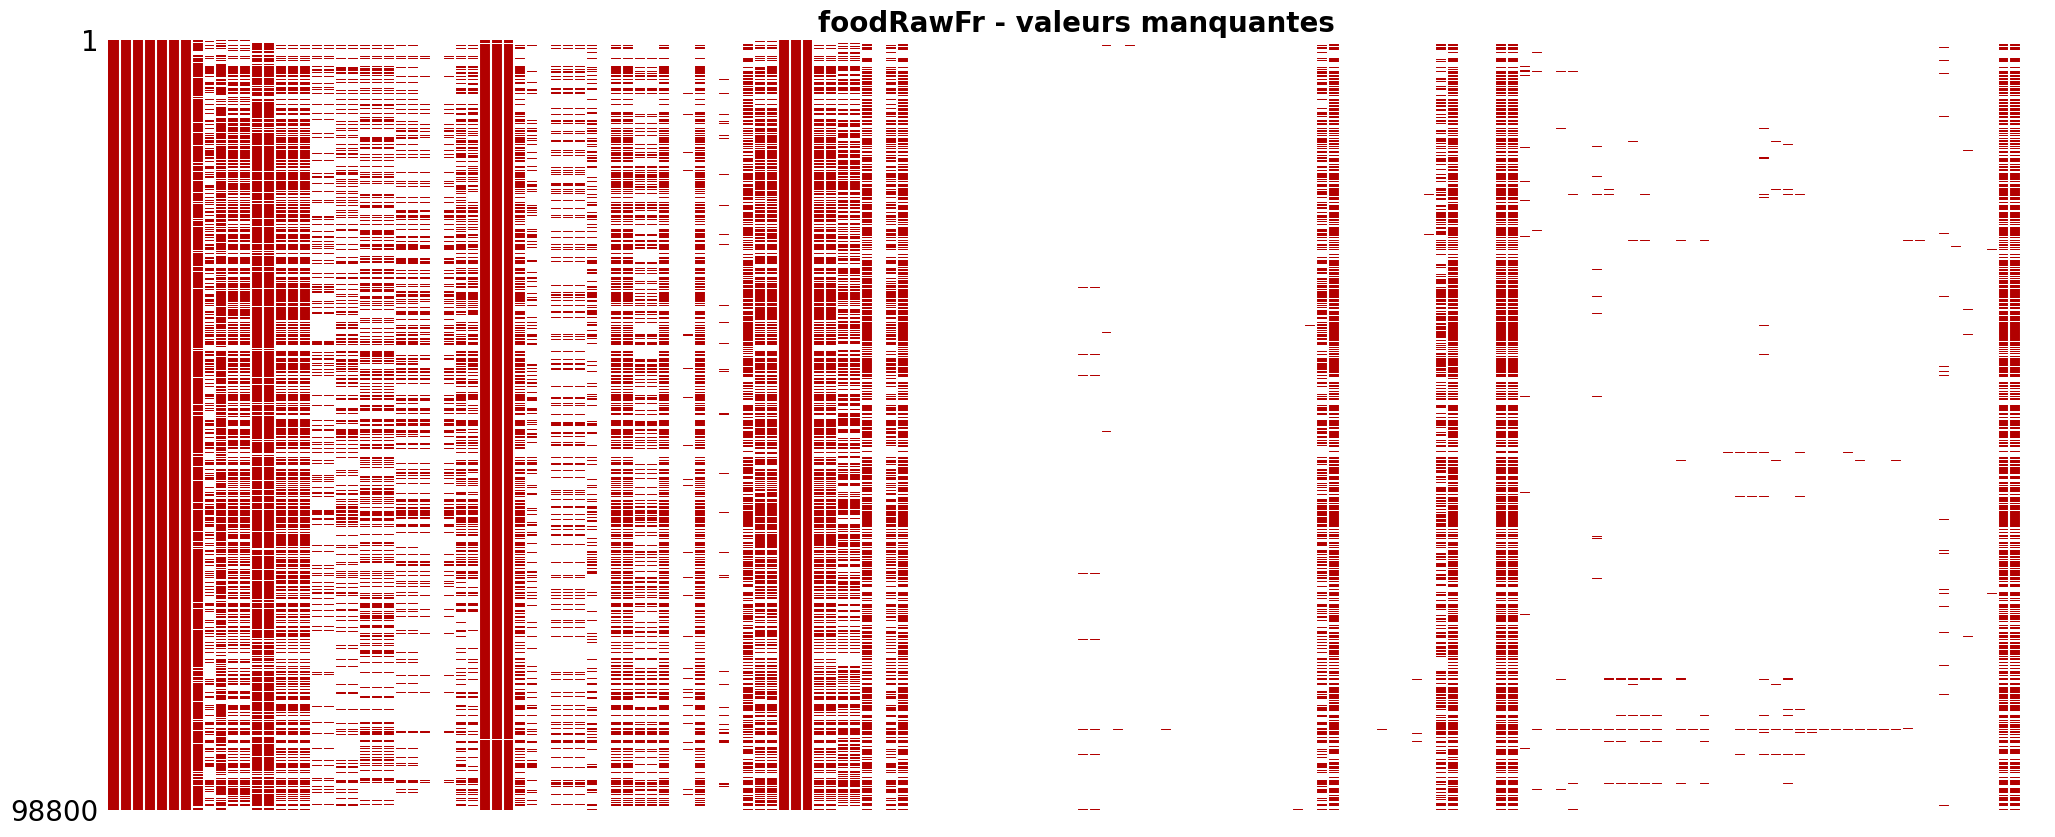

In [28]:
ms.matrix(foodRawFr,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("foodRawFr - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

Le dataset est globalement **très peu renseigné**.

Nous pouvons regarder ce qu'il en est des features qui nous intéressent pour calculer, théoriquement, un MyHealthScore :

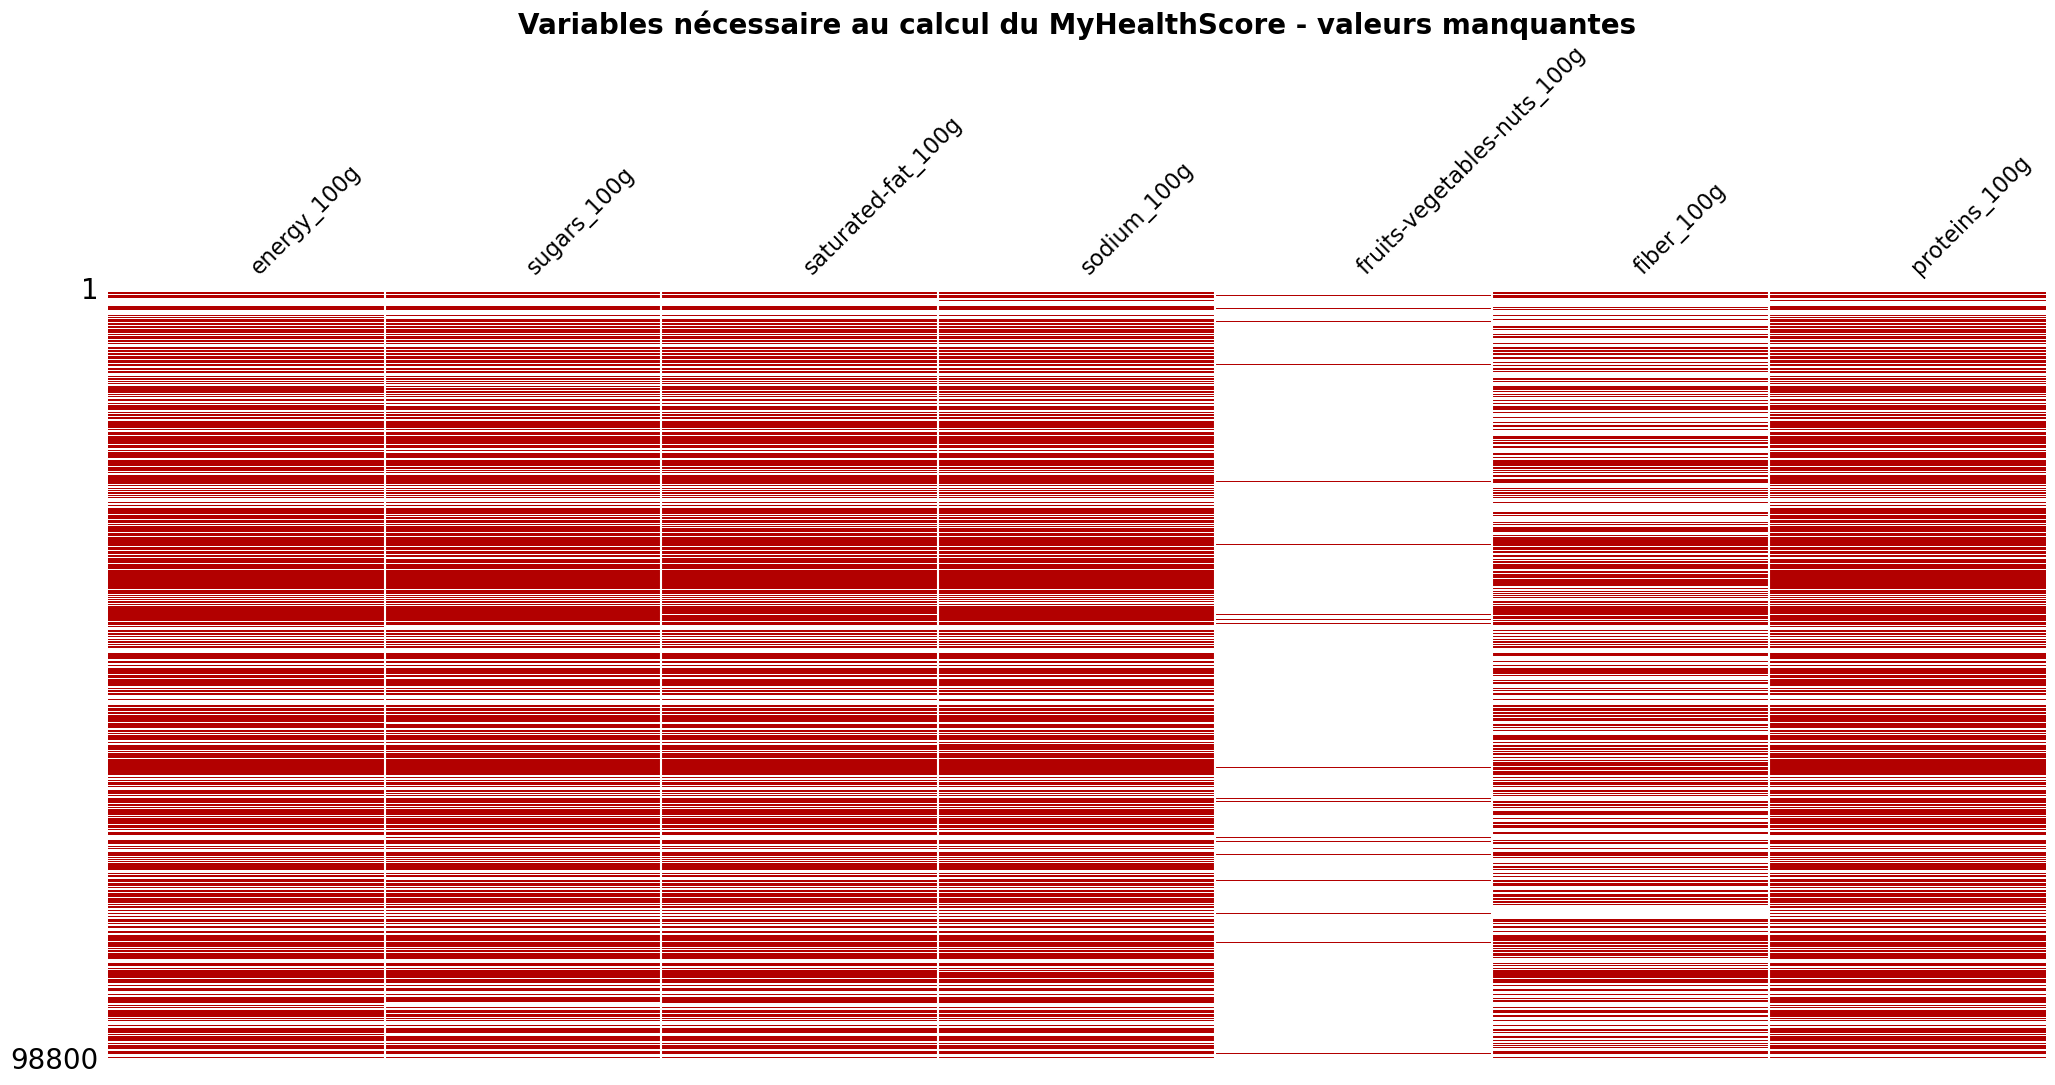

In [29]:
theoricalFeaturesNames=["energy_100g","sugars_100g","saturated-fat_100g","sodium_100g","fruits-vegetables-nuts_100g","fiber_100g","proteins_100g"]
ms.matrix(foodRawFr[theoricalFeaturesNames],color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("Variables nécessaire au calcul du MyHealthScore - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

Malheureusement la feature concernant les **fruits et légumes** est **très peu renseignée**...

Or celle-ci se révèle indispensable pour calculer un MyHealthScore reflétant correctement les recommandations médicales.

Par exemple, si l'on regarde les **préconisations hygiéno-ditétiques pour les personnes atteinte d'hypertension**, le site internet de la **CPAM indique** :
- sel : < 6g /j
- perdre du poids, soit via une IMC < 25 kg/m², soit en perdant 10% du poids initial
- activité physique, soit 30 min/j, soit 3x / semaine
- réduire consommation d'alcool
- augmenter la consommation de **fruits et légumes**
- réduire la consommation de graisses saturées
- arrêter le tabac

La construction d'un MyHealthScore devra donc passer par la prise en compte d'autres colonnes. Pour les déterminer, nous pourrons nous baser dans un premier temps sur le "taux de vide". Regardons ce que cela donne pour les colonnes `theoricalFeaturesNames` :

In [30]:
# percentage of null values in primal selected features :
(foodRawFr[theoricalFeaturesNames].isna().mean()*100).round(1).astype(str)+" %"

energy_100g                    34.5 %
sugars_100g                    36.6 %
saturated-fat_100g             36.8 %
sodium_100g                    36.6 %
fruits-vegetables-nuts_100g    97.0 %
fiber_100g                     53.7 %
proteins_100g                  34.8 %
dtype: object

Nous allons utiliser la fonction `dropEmptyCols`.
Nous avons d'ores et déjà fait une croix sur `fruits-vegetables-nuts_100g`. Basons-nous sur le taux de `fiber_100g` :

In [31]:
foodWithout_54=dropEmptyCols(foodRawFr,emptinessThreshold=0.54)

In [32]:
# check percentage of null values in foodWithout_54
(foodWithout_54.isna().mean().sort_values()*100).round(2).astype(str)+" %"

code                                         0.0 %
url                                          0.0 %
creator                                      0.0 %
created_t                                    0.0 %
last_modified_t                              0.0 %
last_modified_datetime                       0.0 %
created_datetime                             0.0 %
states                                      0.02 %
states_tags                                 0.02 %
states_fr                                   0.02 %
countries                                   0.28 %
countries_tags                              0.28 %
countries_fr                                0.28 %
product_name                                7.36 %
brands                                     12.29 %
brands_tags                                 12.3 %
quantity                                   27.66 %
pnns_groups_2                              31.95 %
pnns_groups_1                              34.14 %
energy_100g                    

N'ayant pas à notre disposition la teneur en fruits et légumes, nous pouvons nous baser sur le Nutri-Score, qui prend en compte celle-ci dans son calcul.

A partir du Nutri-Score, il sera possible dans le cadre du développement de l'application, de créer un MyHealthScore en adaptant les pondérations des autres valeurs nutritionnelles.

On peut donc sélectionner les variables suivantes pour notre analyse :
- `code`, `product_name` et `brands` pour identitifer les produits
- `nutrition-score-fr_100g` qui correspond au socre nutritionnel
- `nutrition_grade_fr` qui correspond au Nutri-Score, l'échelle graphique scindant le score nutritionnel en 5 classes A, B, C, D et E
- `energy_100g`
- `proteins_100g`
- `fiber_100g`
- `sodium_100g` et `salt_100g`, ("salt" est liée à "sodium" par un facteur 2.5. Nous nous servirons de cette variable pour un traitement en particulier, puis nous l'écarterons) 
- `sugars_100g` et `carbohydrates_100g`
- `saturated-fat_100g` et `fat_100g`
- `pnns_groups_2` et `pnns_groups_1` qui permettent de classifier les produits dans des catégories plus ou moins précises

In [33]:
# select work features
workFeatures=["code",
               "product_name",
               "brands",
               "pnns_groups_1",
               "pnns_groups_2",
               "nutrition-score-fr_100g",
               "nutrition_grade_fr",
               "salt_100g",
               "carbohydrates_100g",
               "fat_100g"]+theoricalFeaturesNames
workFeatures.remove("fruits-vegetables-nuts_100g")

In [34]:
foodRawLight = foodRawFr.copy()
foodRawLight = foodRawLight[workFeatures]
foodRawLight

,code,product_name,brands,pnns_groups_1,pnns_groups_2,nutrition-score-fr_100g,nutrition_grade_fr,salt_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated-fat_100g,sodium_100g,fiber_100g,proteins_100g
0,0000000003087,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,Filet de bœuf,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0000000027205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,0000000036252,Lion Peanut x2,Sunridge,unknown,unknown,22.0,e,0.09652,70.0,20.0,1883.0,57.5,12.5,0.038,2.5,2.5
136,0000000039259,Twix x2,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320761,9906410000009,Roussette du Bugey (2011),Roussette du Bugey,NaN,Alcoholic beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320763,99111250,Thé vert Earl grey,Lobodis,Beverages,Non-sugared beverages,2.0,c,0.02540,0.5,0.2,21.0,0.5,0.2,0.010,0.2,0.5
320764,9918,"Cheese cake thé vert, yuzu",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320765,9935010000003,Rillette d'oie,"Sans marque,D.Lambert",Fish Meat Eggs,Processed meat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On peut afficher de nouveau la visualisation des valeurs manquantes :

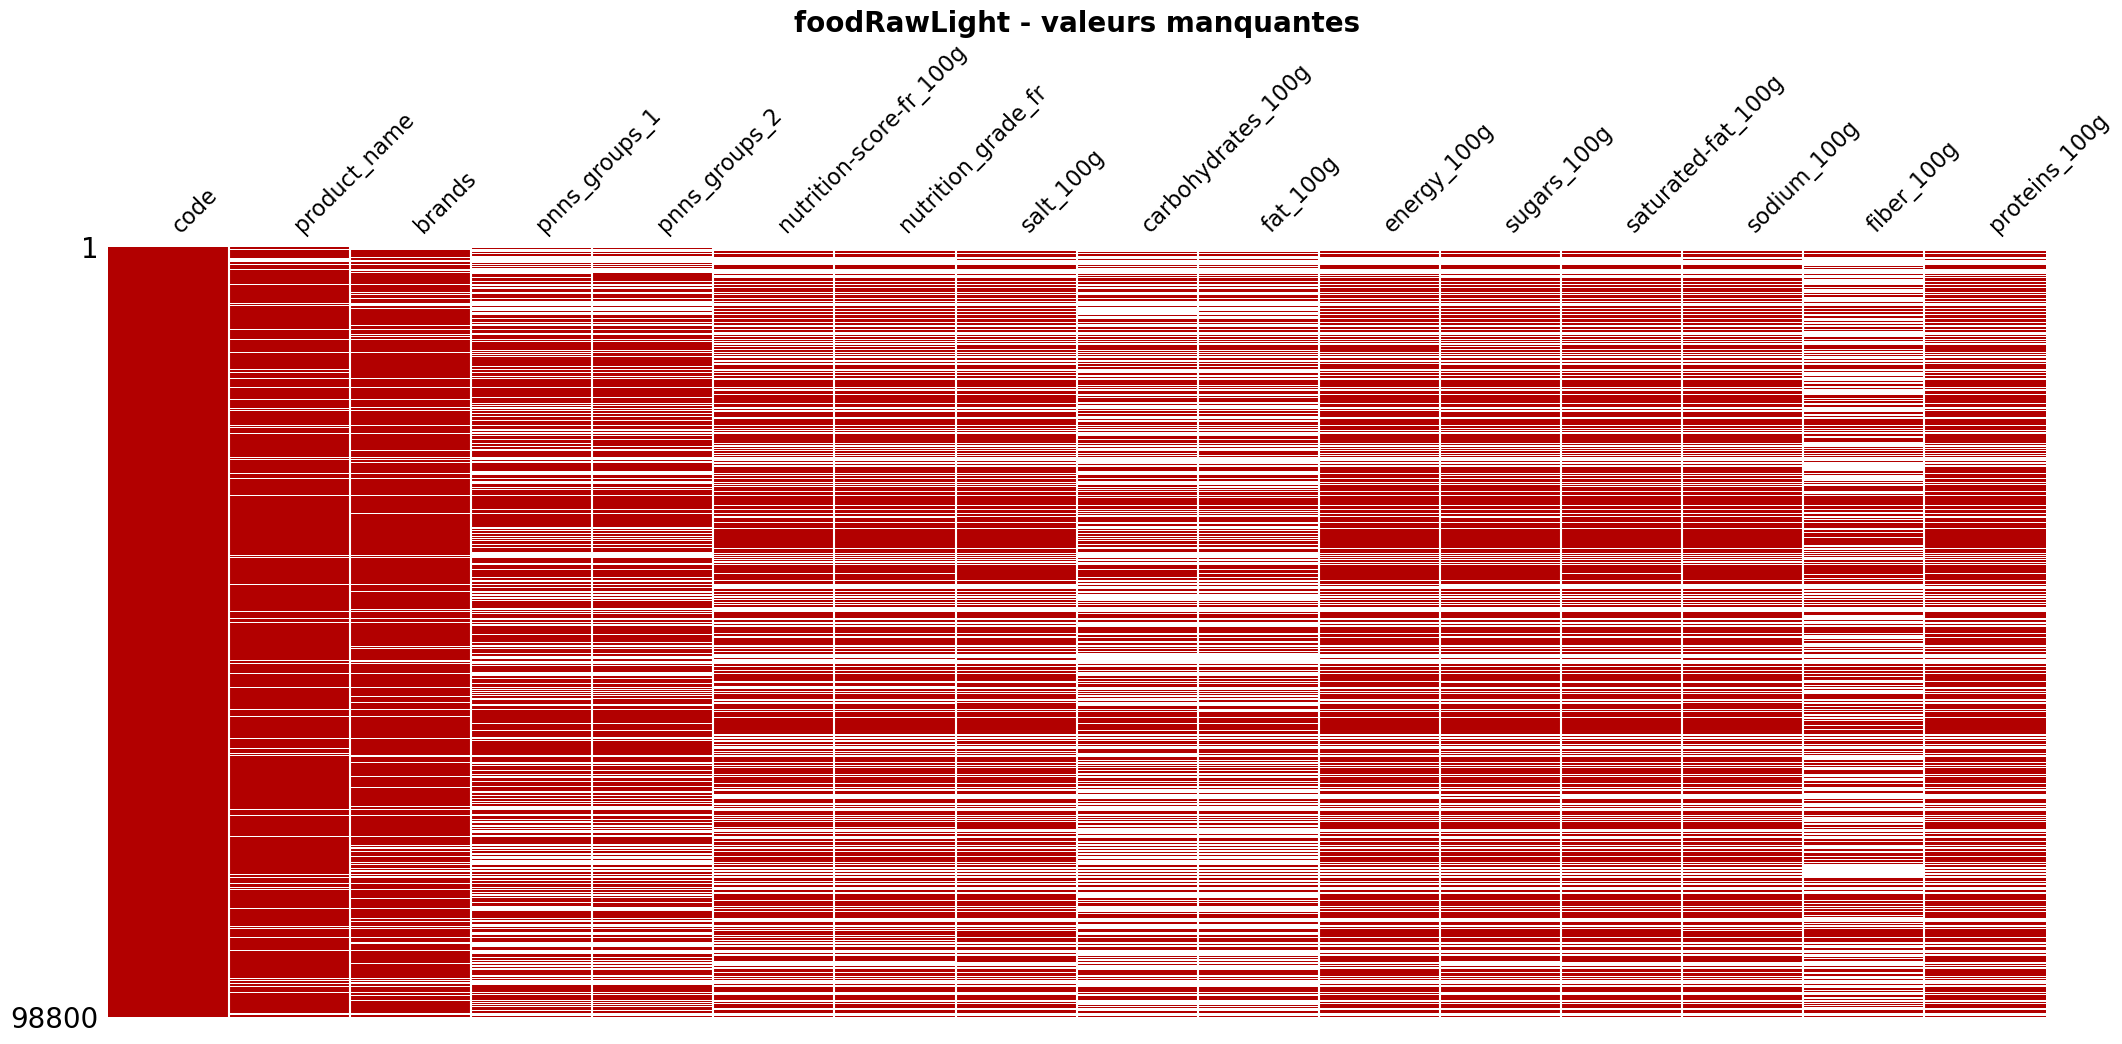

In [35]:
ms.matrix(foodRawLight,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("foodRawLight - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

# Partie 2 - Nettoyage

## P2.1. Nommage des colonnes

Pour faciliter le traitement, nous renommons certaines colonnes pour supprimer les "-" et les remplacer par des "_" :

In [36]:
# use only underscore for column names

foodRawLightUnder=foodRawLight.copy() # create a copy
foodRawLightUnder.rename(columns={col : col.replace("-","_") for col in foodRawLightUnder.columns}, # replace "-" by "_"
                         inplace=True
                        )
workFeatures=foodRawLightUnder.columns.tolist()

## P2.2. Éliminer les doublons

Pour repérer les produit présents deux fois, nous pouvons dans un premier temps regarder la colonne "code".

### P2.2.1. Des produits en double ? "code"

In [37]:
foodRawLightUnder.code.sample(5)

243909    3570701300008
193104    3088541004005
222683    3284230010924
301238    8000500213117
225352    3329770047891
Name: code, dtype: object

le format du code à l'air d'être une suite de 13 chiffres.
Cependant le type "object" de la Series interroge.

In [38]:
# looking to the lenght of "code" values for formatting issues
foodRawLightUnder.code.str.len().value_counts(dropna=False).sort_index()

1         2
2         1
3         2
4         6
5        10
6        32
7        38
8      6186
9         6
10       33
11       30
12       36
13    92329
14       51
15       23
16        3
17        1
22        1
24        4
25        1
31        1
32        2
40        1
41        1
Name: code, dtype: int64

Après quelques recherches, les deux formats les plus représentés correspondent aux systèmes EAN 8 et EAN 13 (EAN pour *European Article Numbering*). Ces deux systèmes sont les plus utilisés en Europe.

Nous faisons le choix de nous séparer des 285 produits aux codes barres non formatés EAN 8 ou 13 : l'usage principal du MyHealthScore se fera via l'application et le scan de code barre.

In [39]:
foodClean01=foodRawLightUnder.copy()
# keep only the values of "code" whose length is 8 or 13
foodClean01=foodClean01.loc[(foodClean01.code.str.len()==8)|(foodClean01.code.str.len()==13)]

Nous pouvons maintenant regarder s'il y a des produits en double :

In [40]:
#look for duplicates in column "code"
foodClean01.loc[foodClean01.code.duplicated(keep=False)]

,code,product_name,brands,pnns_groups_1,pnns_groups_2,nutrition_score_fr_100g,nutrition_grade_fr,salt_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g


Il ne semble pas y avoir de produits différents utilisant le même code-barre.

Une autre manière de repérer les doublons et de regarder la colonne "product_name".

### P2.2.2. Des produits en double ? "product_name" 

Nous n'avons que des produits au code-barre unique. Mais le même produit a pu être étiqueté avec 2 code-barres différents. Regardons.

In [41]:
foodClean01.product_name.value_counts()

Huile d'olive vierge extra        62
Mayonnaise                        54
Moutarde de Dijon                 49
Orange                            46
Spaghetti                         46
                                  ..
3 Œufs avec surprise               1
20 saucisses de Strasbourg         1
Gelée extra Mûre                   1
noir Eclats de fèves 72% cacao     1
Tomates aux Vermicelles            1
Name: product_name, Length: 74413, dtype: int64

Nous ne sommes pas assez précis. Nous ne pouvons pas considérer seulement "product_name" pour rechercher les doublons. Regardons également "brands".

### P2.2.3. Des produits en double ? "product_name" ET "brands"

Regardons si des noms de produits sont présents plusieurs fois sous la même marque :

In [42]:
# look in non null values for "product_name","brands" and "code" for products with the same name and brand :
foodClean01[["product_name","brands",'code']].loc[foodClean01[["product_name","brands",'code']].notna().all(axis=1)].groupby(['product_name',"brands"]).count().sort_values("code",ascending=False).head(10)

,,code
product_name,brands,
Coca-Cola,Coca-Cola,20
Pom'potes,Materne,15
Nutella,"Ferrero,Nutella",14
Orangina,Orangina,14
Nesquik,"Nestlé,Nesquik",11
Perrier,Perrier,11
Auchan,Auchan,10
Nutella,Ferrero,10
Mousline,Maggi,9


Il y a donc des doublons. Ceux-ci peuvent être expliqués par :
- un même produit rentré plusieurs fois sous des codes différents
- un même produit avec des quantités différentes (un pack de 6 bouteilles versus une bouteille seule)

Le score n'a pas vocation à prendre en compte la quantité. Ce sont les qualités intrinsèques du produit, pour 100g en l'occurrence, qui nous intéressent.

Nous allons donc supprimer ces doublons.

In [43]:
foodClean02=foodClean01.copy()
foodClean02=foodClean02.loc[
    (foodClean02[["product_name","brands"]].isna().any(axis=1)) # be carefull to keep the rows where "product_name" or "brands" is NaN
    | # or :
    ~(foodClean02[["product_name","brands"]].duplicated(subset=["product_name","brands"],keep='last')) # non duplicated values for both features
]

In [44]:
print("On a retiré ",foodClean01.shape[0]-foodClean02.shape[0]," produits considérés comme doublons")

On a retiré  3105  produits considérés comme doublons


## P2.3. Traiter "pnns_groups_1" et "pnns_groups_2"

### P2.3.1. Uniformiser le Format

Regardons les modilités de "pnns_groups_1" et "pnns_groups_2" :

In [45]:
foodClean02.pnns_groups_1.value_counts(dropna=False).index.sort_values()

Index([              'Beverages',    'Cereals and potatoes',
               'Composite foods',          'Fat and sauces',
                'Fish Meat Eggs',   'Fruits and vegetables',
       'Milk and dairy products',            'Salty snacks',
                 'Sugary snacks',    'cereals-and-potatoes',
         'fruits-and-vegetables',           'sugary-snacks',
                       'unknown',                       nan],
      dtype='object')

In [46]:
foodClean02.pnns_groups_2.value_counts(dropna=False).index.sort_values()

Index([             'Alcoholic beverages',                       'Appetizers',
       'Artificially sweetened beverages',               'Biscuits and cakes',
                                  'Bread',                'Breakfast cereals',
                                'Cereals',                           'Cheese',
                     'Chocolate products',                   'Dairy desserts',
                   'Dressings and sauces',                     'Dried fruits',
                                   'Eggs',                             'Fats',
                       'Fish and seafood',                     'Fruit juices',
                          'Fruit nectars',                           'Fruits',
                              'Ice cream',                          'Legumes',
                                   'Meat',                  'Milk and yogurt',
                  'Non-sugared beverages',                             'Nuts',
                         'One-dish meals',          

Le format n'a pas l'air unique :
- certaines modalités ont des **tirets séparant les mots**
- certaines modalités ne commencent **pas par une majuscule**
- il y a deux formats différents pour les valeurs manquantes : **"unknown"** et **np.nan**

Traitons cela :

In [47]:
pnns_cols = ["pnns_groups_1","pnns_groups_2"]

# capitalize and replace "-" with " "
foodClean02[pnns_cols] = foodClean02[pnns_cols].applymap(
    lambda x : str(x).capitalize().replace("-"," ") if pd.notna(x) else np.nan 
)


# replace "Unknown" by np.nan
foodClean02[pnns_cols] = foodClean02[pnns_cols].applymap(
    lambda x : np.nan if x == "Unknown" else x
)

### P2.3.2. Traiter simplement quelques valeurs manquantes ?

"pnns_groups_2" représentant des catégories de produits **plus "précises"** que "pnns_groups_1", on peut regarder s'il existe des produits pour lesquels :
- on ne connaît **pas** "pnns_groups_1"
- on **connaît** "pnns_groups_2"

Pour chacune de ces catégories de "pnns_groups_2", nous pourrons regarder les produits concernés pour connaître leurs valeurs de "pnns_groups_1". Si elles sont uniques nous pourrons imputer les valeurs manquantes de "pnns_groups_1" déterminées plus haut.

In [48]:
# look for "pnns_groups_2" values with "pnns_groups_1" missing
mask1na2not = foodClean02.pnns_groups_1.isna()&foodClean02.pnns_groups_2.notna()
foodClean02[pnns_cols].loc[mask1na2not].pnns_groups_2.value_counts()

Alcoholic beverages    2017
Tripe dishes             62
Name: pnns_groups_2, dtype: int64

In [49]:
# keep these categories in a list
pnns_2_cats = foodClean02[pnns_cols].loc[mask1na2not].pnns_groups_2.unique().tolist()

Vérifions maintenant s'il existe des produits dont le "pnns_groups_2" est 'Alcoholic beverages' ou 'Tripe dishes" et où on a un "pnns_groups_1" :

In [50]:
mask = (foodClean02[pnns_cols]["pnns_groups_2"].isin(pnns_2_cats))&(foodClean02[pnns_cols]["pnns_groups_1"].notna())
foodClean02[pnns_cols].loc[mask]

,pnns_groups_1,pnns_groups_2


On ne peut pas imputer en se basant sur des valeurs connues...

On va donc changer de stratégie et choisir des catégories de "pnns_groups_1" qui correspondent **logiquement** à 'Alcoholic beverages' et 'Tripe dishes' :

 **'Beverages'**, <-- 'Alcoholic beverages'<br/>
 'Cereals and potatoes',<br/>
 'Composite foods',<br/>
 'Fat and sauces',<br/>
 '**Fish meat eggs'**, <-- 'Tripe dishes'<br/>
 'Fruits and vegetables',<br/>
 'Milk and dairy products',<br/>
 'Salty snacks',<br/>
 'Sugary snacks'
 
Il ne nous reste plus qu'à vérifier que les valeurs nutritionnelles sont à peu près comparables. Pour cela nous allons regarder la médiane :

In [51]:
# Compare numerical values of  'Beverages' and 'Alcoholic beverages', and 'Fish meat eggs' and  'Tripe dishes'

# create lists...
pnns_1_cats = ['Beverages','Fish meat eggs'] # ... of our selected "pnns_groups_1" values
numColsNames = foodClean02.select_dtypes('float64').columns.tolist() # ... of numericales values

# initiate dataframes to store medians
compareMediansBev = pd.DataFrame()
compareMediansTrip = pd.DataFrame()
lDf=[compareMediansBev,compareMediansTrip]

# store 

for col in pnns_cols :
    for df,cat1,cat2 in zip(lDf,pnns_1_cats,pnns_2_cats) :
        df["dataset"]=foodClean02[numColsNames].median()
        df[cat2+" (pnns2)"]=foodClean02.loc[foodClean02.pnns_groups_2==cat2,numColsNames].median()
        df[cat1+" (pnns1)"]=foodClean02.loc[foodClean02.pnns_groups_1==cat1,numColsNames].median()

display(compareMediansTrip,compareMediansBev)

,dataset,Tripe dishes (pnns2),Fish meat eggs (pnns1)
nutrition_score_fr_100g,9.000000,11.500000,10.000
salt_100g,0.560000,1.100000,1.778
carbohydrates_100g,14.900000,1.900000,0.900
fat_100g,7.000000,11.500000,11.000
energy_100g,1037.000000,743.000000,791.000
sugars_100g,4.000000,1.550000,0.600
saturated_fat_100g,2.000000,5.200000,2.700
sodium_100g,0.220472,0.433071,0.700
fiber_100g,1.400000,1.200000,0.100
proteins_100g,6.000000,12.000000,19.200


,dataset,Alcoholic beverages (pnns2),Beverages (pnns1)
nutrition_score_fr_100g,9.000000,8.000000,6.000000
salt_100g,0.560000,0.010000,0.010000
carbohydrates_100g,14.900000,3.150000,10.000000
fat_100g,7.000000,0.000000,0.000000
energy_100g,1037.000000,181.000000,185.000000
sugars_100g,4.000000,0.500000,9.300000
saturated_fat_100g,2.000000,0.000000,0.000000
sodium_100g,0.220472,0.003937,0.003937
fiber_100g,1.400000,0.000000,0.100000
proteins_100g,6.000000,0.400000,0.300000


La logique est bien respectée :
- La catégorie `Fish meat eggs` de "pnns_groups_1" est proche de `Tripe dishes` de "pnns_groups_1".
- De la même manière la catégorie `Beverages` de "pnns_groups_1" est proche de `Alcoholic beverages` de "pnns_groups_1".

On impute donc :

In [52]:
for i in range(2) :
    foodClean02.loc[(mask1na2not)&(foodClean02.pnns_groups_2==pnns_2_cats[i]),"pnns_groups_1"]=pnns_1_cats[i]

## P2.3. Traiter les outliers

On sait que les outliers ont un impact négatif sur la moyenne et l'écart type empiriques de nos variables. Avant de nous concentrer sur l'imputation des valeurs manquantes, il faut d'abord traiter ces outliers. Regardons dans un premiers temps les valeurs min et max des variables numériques :

In [53]:
foodClean02.describe()

,nutrition_score_fr_100g,salt_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g
count,59076.000000,60197.000000,45154.000000,45585.000000,6.215600e+04,60145.000000,60007.000000,60194.000000,44059.000000,61881.000000
mean,8.676366,1.162005,27.839665,13.293629,1.174376e+03,13.396842,5.451226,0.457503,2.576606,7.787648
std,9.038369,4.261100,27.348395,16.752498,1.308400e+04,19.010655,8.554641,1.677578,4.682310,7.889584
min,-15.000000,0.000000,0.000000,0.000000,0.000000e+00,-0.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.080000,4.100000,1.400000,4.310000e+02,1.000000,0.300000,0.031496,0.000000,1.900000
50%,9.000000,0.560000,14.900000,7.000000,1.037000e+03,4.000000,2.000000,0.220472,1.400000,6.000000
75%,15.000000,1.250000,53.000000,21.000000,1.648000e+03,17.860000,7.500000,0.492126,3.200000,11.000000
max,40.000000,211.000000,190.000000,380.000000,3.251373e+06,105.000000,210.000000,83.000000,178.000000,100.000000


On peut remarquer que :
- il y a des valeurs **négatives** pour les features "nutrition_score_fr_100g", ce qui est normal, et pour **"sugars_100g"**, ce qui devra être traîté
- les valeurs maximales pour les valeurs nutritionnelles " *..._100g* " classiques (hors score nutritionnel et énergie) comportent des irrégularités car **certaines sont supérieures à 100g**...
- après quelques recherches, la quantité maximale d'énergie pour 1g est de 37 kJ/g. Donc théoriquement les valeurs de la colonne **"energy_100g" ne peuvent pas dépasser 3700**, là où le maximum est de 3 251 373... L'écart-type est du coup vraiment impacté : 13084...

Pour la suite de l'étude, on passera la plupart de ces valeurs en valeur manquante.

D'autres opérations de nettoyage seront également menées, aussi basées sur le contexte métier.

### P2.3.1. Masse de sucre négative


In [54]:
# replace negative "sugars_100g" with null values 

foodClean03=foodClean02.copy()
foodClean03.loc[foodClean03.sugars_100g<0,"sugars_100g"]=np.nan

In [55]:
print("On a traité ",((foodClean03.notna())!=(foodClean02.notna())).sum().sum()," produit dont le poids en sucre était négatif")

On a traité  1  produit dont le poids en sucre était négatif


### P2.3.2. Masse de constituant pour 100g supérieure à 100g 


Sélectionnons tout d'abord les features à traiter :

In [56]:
# first, look a columns types
foodClean03.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [57]:
# select numerical columns
componentFeatures=foodClean03.select_dtypes("float64").columns.tolist()
componentFeatures

['nutrition_score_fr_100g',
 'salt_100g',
 'carbohydrates_100g',
 'fat_100g',
 'energy_100g',
 'sugars_100g',
 'saturated_fat_100g',
 'sodium_100g',
 'fiber_100g',
 'proteins_100g']

In [58]:
# exclude "non component" columns
componentFeatures.remove("nutrition_score_fr_100g")
componentFeatures.remove("energy_100g")

In [59]:
# search for "..._100g" > 100
foodClean04=foodClean03.copy()
foodClean04.loc[(foodClean04[componentFeatures]>100).any(axis=1),componentFeatures]

,salt_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g
155609,NaN,164.0,0.0,72.7,0.00,NaN,NaN,0.0
202571,0.14000,104.0,0.0,104.0,0.00,0.055100,0.000,0.0
232239,211.00000,47.8,23.0,26.7,3.33,83.000000,0.741,6.3
233372,125.00000,0.0,0.0,0.0,0.00,49.212598,0.000,0.0
234726,1.30048,106.0,52.0,52.0,35.50,0.512000,3.000,10.0
239347,NaN,105.0,NaN,105.0,NaN,NaN,NaN,NaN
245311,9.33000,190.0,380.0,22.7,210.00,3.670000,0.000,0.0
260599,0.10000,103.5,1.0,103.5,0.10,0.039370,NaN,1.0
298897,0.37000,59.0,29.0,58.0,18.00,0.145669,178.000,6.3
305054,0.01000,70.0,105.0,2.5,0.30,0.003937,NaN,12.0


In [60]:
# replace "..._100g" > 100 with null value
foodClean04[componentFeatures]=foodClean04[componentFeatures].mask(foodClean04[componentFeatures]>100,np.nan)

In [61]:
print("On a passé en valeur manquante ",
      ((foodClean03.notna())!=(foodClean04.notna())).sum().sum(),
      " masses qui étaient supérieures à 100g")

On a passé en valeur manquante  18  masses qui étaient supérieures à 100g


### P2.3.3. Énergie pour 100g supérieure à 3700 kJ.


In [62]:
# search products with energy_100g > 3700

foodClean05=foodClean04.copy()
foodClean05.loc[(foodClean05.energy_100g>3700),["product_name","energy_100g"]].sort_values("energy_100g").sample(15)

,product_name,energy_100g
210532,Huile de noisette,3766.0
234018,Huile De Noisette Biologique,3766.0
241696,Fond de veau,5598.0
258203,Huile vierge de coco,3766.0
277678,Chocolat Liquide,4786.0
254270,Huile Olive Paliga,3766.0
226190,Huile de pepins de Courge bio,3766.0
271532,Pure coconut oil,3761.0
210331,"Huile d'olive Extra Vierge, extraite à froid",3766.0
257640,Huile de coco vierge,3766.0


Cette échantillons nous indique que les produits en question semblent être majoritairement des huiles. Après quelques recherches, on sait que ces produits ont une valeur énergétique de 900 kcal (3700 kJ). On va donc appliquer deux traitement différents :
- imputer à 3700 pour les produits dont le nom contient "huile"
- imputer à NaN pour les autres produits concernés

In [63]:
# mask for "energy_100g" > 3700 and product is an oil
above3700andOilMask = ((foodClean05.energy_100g>3700)
                &(foodClean05.product_name.notna())
                &(
                    (foodClean05.product_name.str.find("Huile")!=-1) 
                    |(foodClean05.product_name.str.find("huile")!=-1) 
                    |(foodClean05.product_name.str.find(" Oil ")!=-1) 
                    |(foodClean05.product_name.str.find(" oil ")!=-1)
                )
               )

In [64]:
# replace "energy_100g" with 3700
foodClean05.loc[above3700andOilMask,"energy_100g"]=3700

In [65]:
print("On a passé à 3700 kJ ",above3700andOilMask.sum()," valeurs énergétiques d'huiles qui étaient supérieures à 3700 kJ")

On a passé à 3700 kJ  131  valeurs énergétiques d'huiles qui étaient supérieures à 3700 kJ


In [66]:
foodClean05.loc[(foodClean05.energy_100g>3700),"energy_100g"]=np.nan

In [67]:
print("On a passé à valeur manquante ",
      ((foodClean04.notna())!=(foodClean05.notna())).sum().sum(),
      " valeurs énergétiques restantes, qui étaient supérieures à 3700 kJ")

On a passé à valeur manquante  123  valeurs énergétiques restantes, qui étaient supérieures à 3700 kJ


### P2.3.4. Sommes des masses des constituants PRINCIPAUX VS 100g

On peut aussi s'interroger sur les constituants dans leur ensemble. En effet, la somme des différents constituants "..._100g" ne devrait pas faire plus de 100g.

La question est de savoir quels constituants sommer. En effet certains sont des sous-produits d'autres constituants...

Après un peu de recherche (source https://ciqual.anses.fr/#/cms/questions-reponses/node/23), les "macro-constituants", dont la somme est censée être égale à 100, sont les suivants : **protéines, glucides totaux, lipides, alcool, cendres et eau**. Balayons ces différents éléments :

- proteins_100g : ok
- carbohydrates_100g : ok
- fat_100g : ok
- alcohol_100g : a été retiré du dataframe... Nous pouvons le réintégrer provisoirement
- cendres : correspondent au minéraux. Il ne nous reste que le sodium (sel)
- eau : ne fait pas partie de nos données

Nous allons nous concentrer sur les composants principaux à notre disposition. **Si la somme de ces masses est supérieure à 100g, et ce même sans les informations manquantes (on pense notamment à l'eau), alors nous écarterons le produit en question.**

In [68]:
# main nutrients column names 
macroNutCols=[
    'alcohol_100g',
    'proteins_100g',
    'carbohydrates_100g',
    'fat_100g',
    'salt_100g'
]

# create a dataframe with "alcohol_100g" back in
foodClean_WithAlcohol=foodClean05.copy()
foodClean_WithAlcohol['alcohol_100g']=foodRaw.loc[foodClean_WithAlcohol.index,"alcohol_100g"]

In [69]:
# compute the sum and put it in a Series

foodClean_WithAlcohol["sumOfMacro"]=foodClean_WithAlcohol[macroNutCols].sum(axis=1)
foodClean_WithAlcohol["sumOfMacro"]

0          0.00000
46         0.00000
48         0.00000
106       92.59652
136        0.00000
            ...   
320760     0.00000
320761    12.00000
320763     1.22540
320765     0.00000
320770     0.00000
Name: sumOfMacro, Length: 95410, dtype: float64

In [70]:
# create au mask for "sumOfMacro" > 100
mask_MacroAbove100=foodClean_WithAlcohol["sumOfMacro"]>100
# look at concerned products
foodClean_WithAlcohol.loc[mask_MacroAbove100,macroNutCols+["sumOfMacro"]].sort_values("sumOfMacro")

,alcohol_100g,proteins_100g,carbohydrates_100g,fat_100g,salt_100g,sumOfMacro
204888,0.0,0.00,0.0,100.0,0.00254,100.00254
184775,NaN,0.50,99.0,0.5,0.01000,100.01000
315944,NaN,0.50,99.0,0.5,0.01000,100.01000
210332,NaN,0.02,0.0,100.0,0.00000,100.02000
223303,NaN,0.00,0.0,100.0,0.02500,100.02500
...,...,...,...,...,...,...
285429,NaN,100.00,NaN,NaN,50.00000,150.00000
177924,NaN,5.40,69.4,87.0,0.38000,162.18000
197179,NaN,48.10,97.7,21.9,NaN,167.70000
286048,NaN,90.00,49.0,39.0,0.01000,178.01000


Certaines sommes >100 ne le sont que très légèrement.

Nous allons donc :
- fixer un seuil sur la somme **en deça** duquel nous ne ferons que **corriger** les masses
- **remplacer** les masses **par nan** seulement si la sommes est **au dessus** du seuil

In [71]:
# create a 5% threshold for "sumOfMacro"
above100Threshold = 100*1.05

# create a mask
maskUnderThreshold = foodClean_WithAlcohol["sumOfMacro"]<above100Threshold

# keep the concerned index
indexUnderThreshold=foodClean_WithAlcohol.loc[mask_MacroAbove100&maskUnderThreshold,macroNutCols+["sumOfMacro"]].index

# adjust the "..._100g" values so the sum is under 100
foodClean06=foodClean05.copy() # create copy
macroNutCols.remove('alcohol_100g') # remove 'alcohol_100g' from the macroNutCols list
foodClean06.loc[indexUnderThreshold,macroNutCols]=(foodClean06.loc[indexUnderThreshold,macroNutCols].
                                                   multiply(100/foodClean_WithAlcohol.loc[indexUnderThreshold,"sumOfMacro"],
                                                            axis=0)
                                                  )

In [72]:
print("On a ajusté les masses des composants principaux de ",
      len(indexUnderThreshold),
      " produits afin que leur somme ne dépasse pas 100g"
     )

On a ajusté les masses des composants principaux de  86  produits afin que leur somme ne dépasse pas 100g


In [73]:
# for sums above threshold, replace ".._100g" values with np.nan

# find the index
indexAboveThreshold = foodClean_WithAlcohol.loc[mask_MacroAbove100&(~maskUnderThreshold),macroNutCols+["sumOfMacro"]].index

# replace the "..._100g" values with np.nan
foodClean06.loc[indexAboveThreshold,macroNutCols]=np.nan

In [74]:
print("On a passé à valeur manquante ",
      ((foodClean05.notna())!=(foodClean06.notna())).sum().sum(),
      " masses restantes, dont la somme dépassait le seuil fixé")

On a passé à valeur manquante  164  masses restantes, dont la somme dépassait le seuil fixé


Maintenant que nous avons utilisé "Salt_100g", **nous pouvons nous en séparer**. Vérifions tout de même di elle pourrait servir à imputer "sodium_100g" :

In [75]:
# check if there are products with null values for "salt" and non-null value for "sodium", and vice versa
foodSaltAndNotSodium=foodClean06[["salt_100g","sodium_100g"]].loc[(foodClean06.salt_100g.notna())&(foodClean06.sodium_100g.isna())]
foodSaltAndNotSodium

,salt_100g,sodium_100g
192840,0.1016,NaN
254025,0.0000,NaN
282383,0.0254,NaN


Il n'y a que trois valeurs. Imputons-les tout de même rapidement :

In [76]:
# impute these 3 "sodium_100g" null values with "salt_100g"  divided by 2.5
foodClean06.loc[foodSaltAndNotSodium.index,"sodium_100g"]=foodClean06.loc[foodSaltAndNotSodium.index,"salt_100g"]/2.5

In [77]:
# remove "salt_100g"
componentFeatures.remove("salt_100g")

In [78]:
workFeatures.remove("salt_100g")

In [79]:
foodClean06=foodClean06[workFeatures]

### P2.3.5. Masse d'un sous-composant > macro-composant

Sur le même principe, un sous-produit ne devrait pas avoir une masse supérieure à celle du produit principal.

Si l'on se concentre sur nos features, voici les comparaisons à mener :
- "sugars_100g" > "carbohydrates_100g"
- "saturated_fat_100g" > "fat_100g"

In [80]:
# create masks with subcomponent > main component

thresholdRate=1.10
mask_SatfatAboveFat=(
    (foodClean06['saturated_fat_100g']>foodClean06["fat_100g"]*thresholdRate)
     &(foodClean06["fat_100g"].notna())
)
    

mask_SugarAboveCarbo=(
    (foodClean06['sugars_100g']>foodClean06['carbohydrates_100g']*thresholdRate)
    &(foodClean06['carbohydrates_100g'].notna())
)

In [81]:
foodClean06.loc[mask_SatfatAboveFat,['saturated_fat_100g',"fat_100g","product_name"]]

,saturated_fat_100g,fat_100g,product_name
6570,1.0,0.0,Algues Wakame Pour Soupe Ou Salade WEL-PAC 56.7G
54995,15.0,5.0,Malt O Meal Cereal Coco Roos 23.
57332,0.9,0.0,Mae Ploy Chilli Sauce Sweet For Chicken - 25fl...
59062,0.1,0.0,Vinaigre Pour Sushi
99205,0.1,0.0,Panda Brand Oyster Sauce
...,...,...,...
302974,0.5,0.3,Tic Tac - Menthe
303082,0.5,0.0,Tic Tac Menthe
305772,1.6,0.0,Buongrano
315953,0.1,0.0,"Lipton Alps 20X1.1 GR, 1 Boîte"


In [82]:
foodClean06.loc[mask_SugarAboveCarbo,['sugars_100g',"carbohydrates_100g","product_name"]]

,sugars_100g,carbohydrates_100g,product_name
149836,15.0,6.25,Alo exposed
177460,48.6,7.05,"Favorina, Haselnuss Nougat Eier"
178306,3.9,3.50,Fromage blanc 20 % nature
178588,2.2,1.72,Foie gras de canard entier
179979,3.0,2.00,Chèvre frais
...,...,...,...
305772,20.5,0.00,Buongrano
310167,0.3,0.10,Chiffonade
312063,2.0,1.60,Filets d'anchois à l'huile d'olive
315480,26.0,23.00,Ben & Jerry's - Fairly Nuts


In [83]:
# replace values with NaN
foodClean07=foodClean06.copy()
foodClean07.loc[mask_SatfatAboveFat,["fat_100g"]]=np.nan
foodClean07.loc[mask_SugarAboveCarbo,['carbohydrates_100g']]=np.nan

In [84]:
print("On a passé à valeur manquante ",
      ((foodClean07.notna())!=(foodClean06.notna())).sum().sum(),
      " masses de composants incohérentes entre elles")

On a passé à valeur manquante  140  masses de composants incohérentes entre elles


### P2.3.6. Traitement des outliers, impact sur la moyenne et l'écart-type

La moyenne est l'écart-type sont sensibles aux outliers. Nous pouvons regarder si les traitements précédents ont eu un effet positif.

Pour cela nous allons étudier l'évolution de ces statistiques au fil des étapes de nettoyage.

In [85]:
# put the different foodClean## in a list
listFoodCleanDfs = [
    foodClean02,
    foodClean03,
    foodClean04,
    foodClean05,
    foodClean06,
    foodClean07
]

# list of names of numerical features
numericalFeatureNames=foodClean07.select_dtypes("float64").columns.tolist()
numericalFeatureNames.remove("nutrition_score_fr_100g")
numericalFeatureNames.remove("energy_100g")
numericalFeatureNames.remove("sodium_100g")
numericalFeatureNames.append("sodium_100g")
numericalFeatureNames.append("energy_100g")
# put "sodium_100g" and "energy_100g" at the end of the list

# list of lists to store the empirical means of each numerical feature, for each cleaned dataframe
listOfMeans=[
    [listFoodCleanDfs[i][col].mean() for col in  numericalFeatureNames] 
    for i in range(len(listFoodCleanDfs))
]

# list of lists to store the empirical stds of each numerical feature, for each cleaned dataframe
listOfStds=[
    [listFoodCleanDfs[i][col].std(ddof=1) for col in  numericalFeatureNames] 
    for i in range(len(listFoodCleanDfs))
] 

In [86]:
# lists to store the evolution between each cleaning stage
listEvolOfStd=[
    [(listOfStds[i+1][idxcol]-listOfStds[i][idxcol])/listOfStds[i][idxcol] for idxcol in range(len(numericalFeatureNames))] 
    for i in range(len(listFoodCleanDfs)-1)
]

listEvolOfMean=[
    [(listOfMeans[i+1][idxcol]-listOfMeans[i][idxcol])/listOfMeans[i][idxcol] for idxcol in range(len(numericalFeatureNames))] 
    for i in range(len(listOfMeans)-1)
]

# cum sum
cumSumEvolOfStd=np.cumsum(listEvolOfStd,axis=0)
cumSumEvolOfMean=np.cumsum(listEvolOfMean,axis=0)

Pour une meilleure interprétation, nous allons représenter ces évolutions sur des graphiques.

Nous allons tout d'abord attribuer à chaque feature sélectionnée une couleur. Cela nous aidera à bien les identifier sur chaque représentation graphique.

In [87]:
# create a custom palette
palette=(sns.color_palette("Paired")+
         [sns.color_palette("Accent")[7],
          sns.color_palette("Accent")[5],
          sns.color_palette("Dark2")[4]]
        )

foodPaletteDict={colName : colorRGB for colName,colorRGB in zip(foodClean07,palette)}

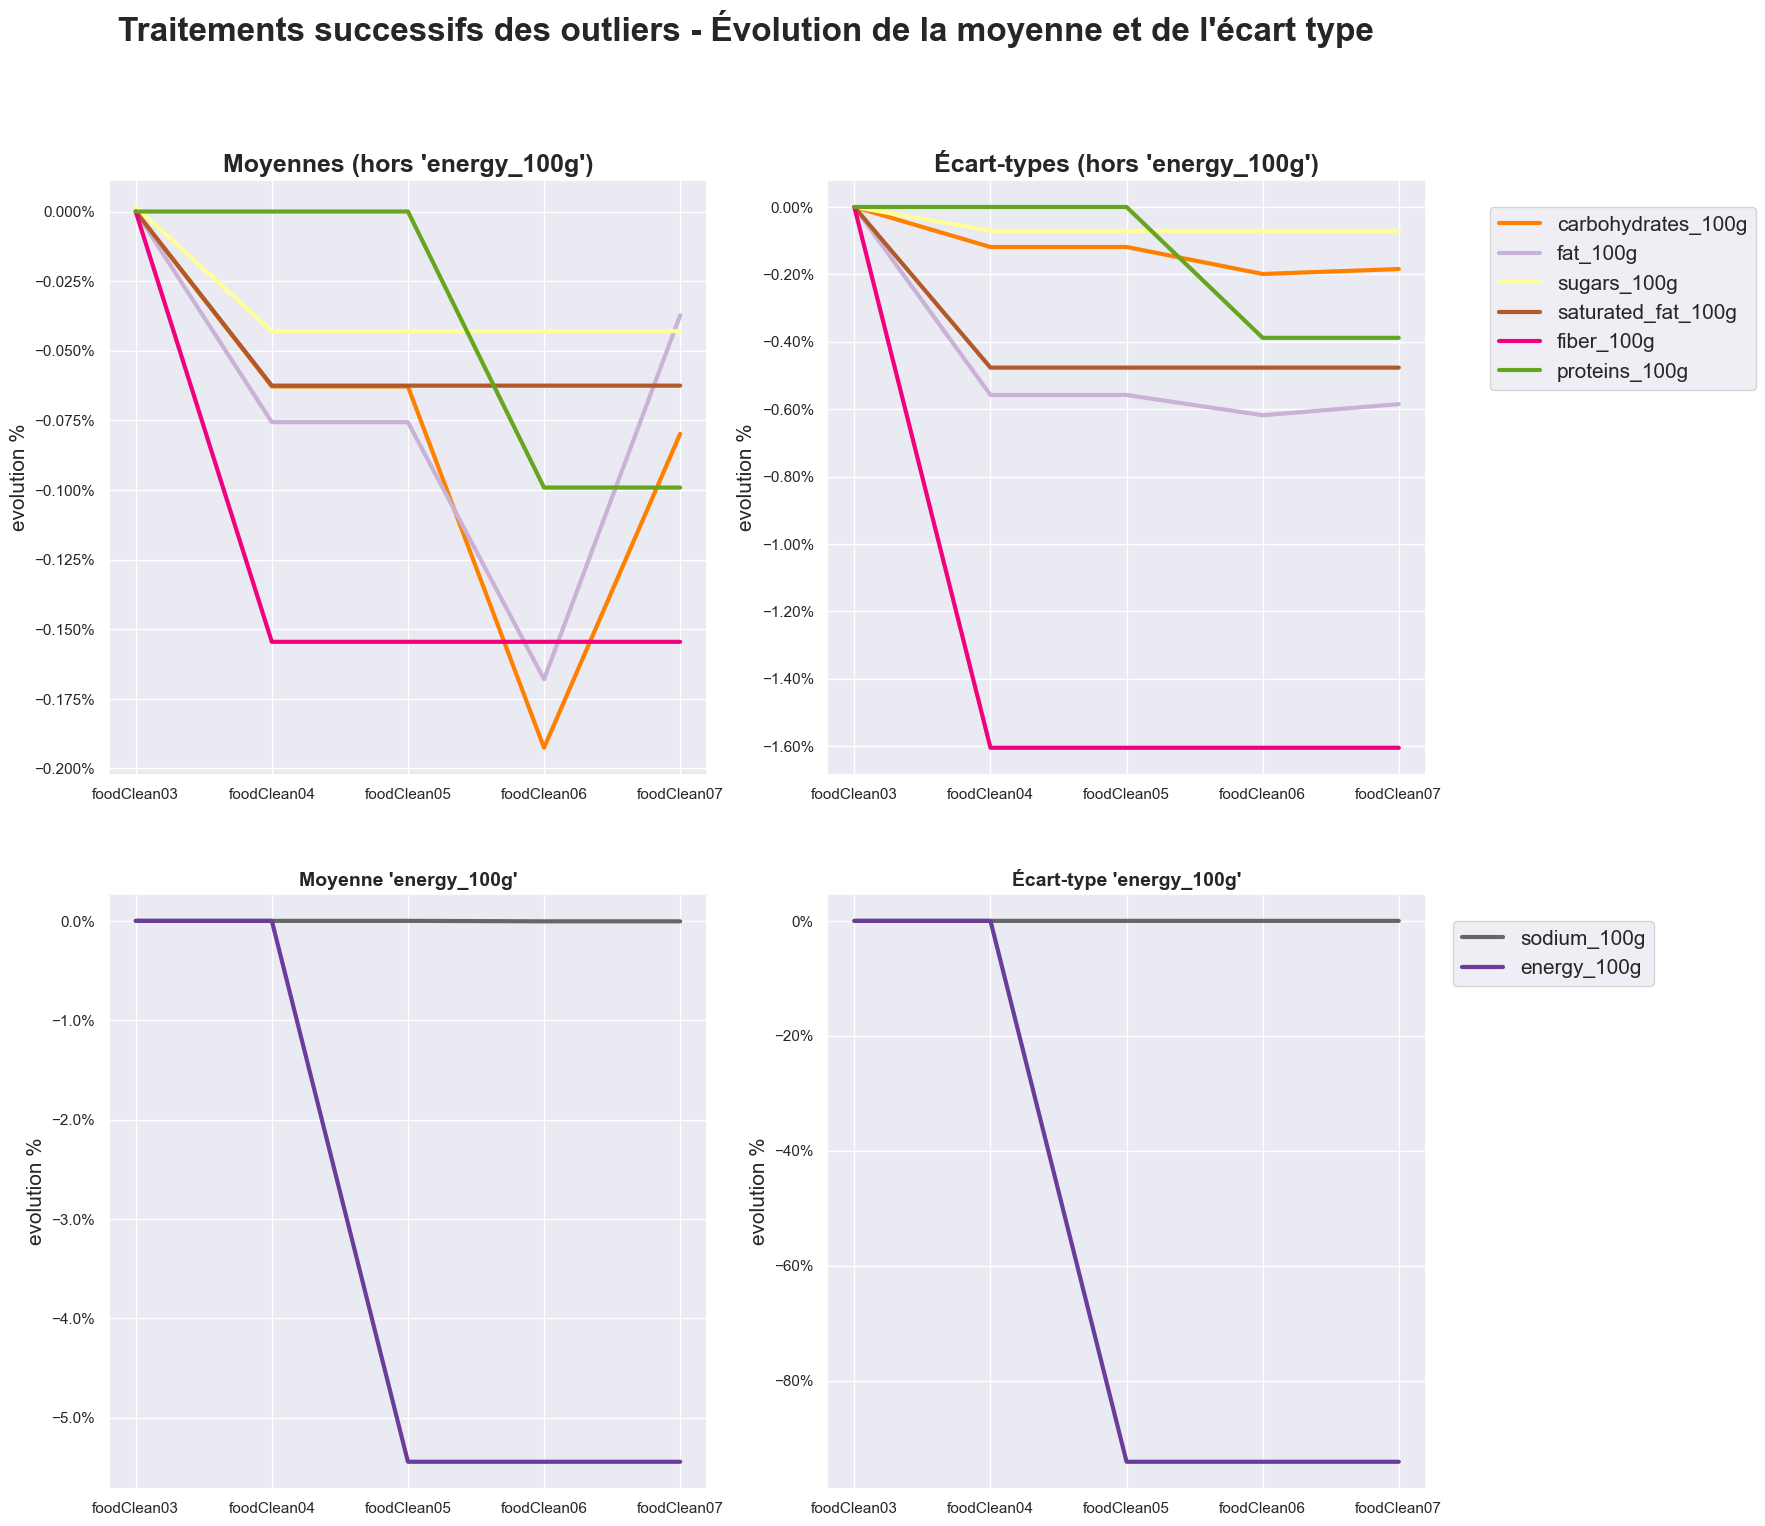

In [88]:
# visualisations of empirical mean and std evolution for each cleaning stage
sns.set_theme()
fig,axs=plt.subplots(2,2,sharex=False,figsize=(17,17)) # 4 plots 

axs=axs.reshape(axs.size) # reshape for easier iteration



for idxCol in range(len(numericalFeatureNames)) :
    
    X=[i+3 for i in range(len(listFoodCleanDfs)-1)] # set x axis
    
    if (idxCol!=numericalFeatureNames.index("energy_100g") 
        and 
        idxCol!=numericalFeatureNames.index("sodium_100g")) : # cleaning on "energy_100g" had more impact --> separate plots
        
        sns.lineplot(
            ax=axs[0],
            x=X,
            y=[cumSumEvolOfMean[i][idxCol] for i in range(len(listFoodCleanDfs)-1)],
            linewidth = 3,
            color=foodPaletteDict[numericalFeatureNames[idxCol]]
        )
        
        sns.lineplot(
            ax=axs[1],
            x=X,
            y=[cumSumEvolOfStd[i][idxCol] for i in range(len(listFoodCleanDfs)-1)],
            linewidth = 3,
            color=foodPaletteDict[numericalFeatureNames[idxCol]]
        )
        
    else :
        sns.lineplot(
            ax=axs[2],
            x=X,
            y=[cumSumEvolOfMean[i][idxCol] for i in range(len(listFoodCleanDfs)-1)],
            linewidth = 3,
            color=foodPaletteDict[numericalFeatureNames[idxCol]]
        )
        
        sns.lineplot(
            ax=axs[3],
            x=X,
            y=[cumSumEvolOfStd[i][idxCol] for i in range(len(listFoodCleanDfs)-1)],
            linewidth = 3,
            color=foodPaletteDict[numericalFeatureNames[idxCol]]
        )

# axs titles
axs[0].set_title("Moyennes (hors 'energy_100g')", fontweight="bold",fontsize=18) 
axs[1].set_title("Écart-types (hors 'energy_100g')", fontweight="bold",fontsize=18) 
axs[2].set_title("Moyenne 'energy_100g'", fontweight="bold",fontsize=14) 
axs[3].set_title("Écart-type 'energy_100g'", fontweight="bold",fontsize=14) 

# for each plot
for i in range(len(axs)) :
    axs[i].set_xticks([3,4,5,6,7]) # 1 tick for 1 cleaning stage 
    axs[i].set_xticklabels(["foodClean0"+str(i+3) for i in range(5)]) # name xticks with names of dataframes
    axs[i].set_ylabel("evolution %",fontsize=15) # set y label
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1)) # use matplotlib.ticker to format y axis as percent
    
fig.legend(numericalFeatureNames[:-2],bbox_to_anchor=(1.1,0.87),fontsize=15) # set legend - each numerical feature name...
legEnergySod=fig.legend(numericalFeatureNames[-2:],bbox_to_anchor=(1.04,0.45),fontsize=15) # ... except for "energy_100g" and "sodium_100g", on a different legend
legEnergySod.legendHandles[0].set_color(foodPaletteDict["sodium_100g"]) # choose the right color from the palette for energy legend
legEnergySod.legendHandles[1].set_color(foodPaletteDict["energy_100g"])
fig.suptitle("Traitements successifs des outliers - Évolution de la moyenne et de l'écart type", fontweight="bold",fontsize=24) # main title

plt.show()


Les différentes étapes de **nettoyage sur les outliers** ont globalement **diminué les moyennes et écarts-types empiriques** des features concernées.

La dernière étape (imputation par NaN de masses en glucides et en gras) a en revanche eu un effet opposé, ce qui est logique car nous avons retiré des valeurs basses.

L'opération sur **"energy_100g"** (fixer une borne haute à 3700 KJ) a eu un impact **très important**.

## P2.4. Traiter les valeurs manquantes

### P2.4.1. Nettoyage des valeurs manquantes : produits trop mal renseignés

Nous allons **dans un premier temps** réaliser une nouvelle opération de nettoyage, cette fois en **nous séparant totalement des produits ne contenant que très peu d'information nutritionnelle**.

En effet il y a de nombreux produits où nous ne connaissons pas la moindre masse en nutriments :

In [89]:
# number of rows with all component masses missing
print("Il y a ",
      len(foodClean07.loc[foodClean07[componentFeatures].isna().all(axis=1)]),
      " produits dont nous ne connaissons la moindre masse en nutriments"
     )

Il y a  32750  produits dont nous ne connaissons la moindre masse en nutriments


Sans ces informations il sera difficile de considérer ces produits dans le cadre de l'analyse, et surtout dans le cadre de la création de l'app.

Nous pourrions nous poser la question de l'imputation de celles-ci, mais :
- `Iterative Imputer` et `KNN Imputer` ne pourront imputer ces lignes **qu'avec la valeur moyenne de chaque feature**
- un filtrage préalable sur les modalités d'une variable catégorielle n'apportera pas beaucoup plus de précision

Nous faisons donc le choix **de nous séparer de ces produits**.

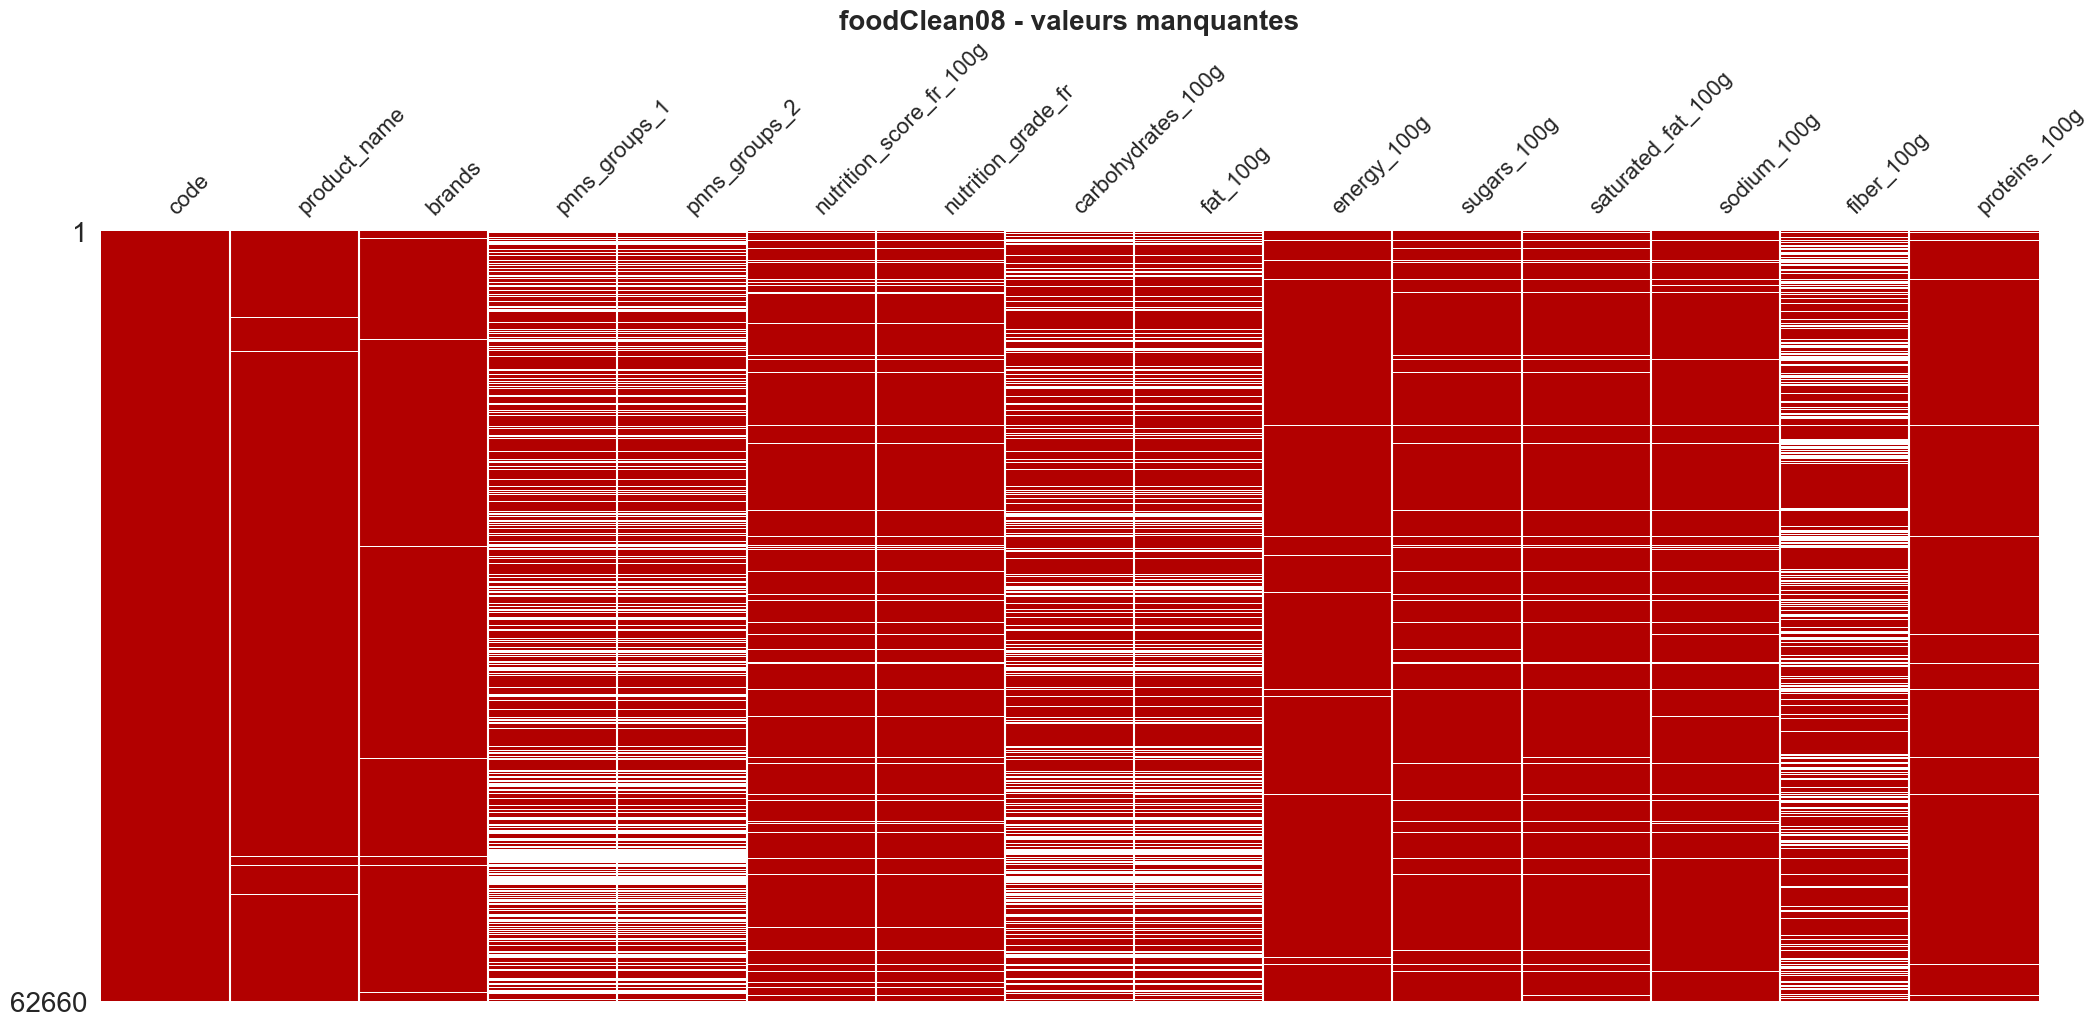

In [90]:
# exclude rows with all component masses missing

foodClean08=foodClean07.copy()
foodClean08=foodClean08.loc[foodClean08[componentFeatures].notna().any(axis=1)]

# visualisation
ms.matrix(foodClean08,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("foodClean08 - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

### P2.4.2. Imputations - Préambule

Dans le cadre du traitement des valeurs manquantes, nous allons tester différentes méthodes d'imputation :
- **Iterative Imputer**, pour les variables numériques
- **KNN Imputer**, pour les variables numériques
- **Utilisation d'une fonction d'imputation**, pour les variables catégorielles

Afin de tester la pertinence de tel ou tel imputeur, nous allons :
- retirer les features "code", "product_name", "brands", "nutrition_grade_fr", qui ne seront pas imputées
- conserver la feature "nutrition_score_fr_100g" :

    **Cette feature est celle pour laquelle nous préparons le jeu de données. Dans le cadre d'une éventuelle future phase du projet l'objectif serait de faire des prédictions sur "nutrition_score_fr_100g", et ensuite l'utiliser pour construire un MyHealthScore. Elle serait donc notre variable dépendente.**
    
    **L'objectif n'est donc pas de réaliser des imputations. Cependant, nous conserverons cette feature lors des opérations d'imputation sur les autres car :**
    - **il existe des relations entre celle-ci et les autres (car le score nutritionnel est construit à partir des autres feature numériques)**
    - **imputer les autres features sans le score nutritionnel biaiserait alors ces éventuelles futures prédictions**

        A noter que pour l'analyse nous conserverons ses valeurs imputées. Elles seraient retirée du dataset dans le cadre d'un projet de prédiction (celles-ci n'apporteraient que du bruit dans le cadre d'une régression)
    
    
- scaler les features "nutrition_score_fr_100g" et "energy_100g" afin qu'elle soit sur la **même échelle que les autres variables numériques**
- **créer** un dataframe test en générant **artificiellement des valeurs manquantes**. Nous pourrons ainsi voir quel imputeur est le plus performant

### P2.4.3. Création d'un dataframe de test pour les imputations

Nous souhaitons créer un dataframe de test reproduisant à peu près la répartition des valeurs manquantes de notre dataframe.

Nous allons utiliser la fonction créée précédemment. Tout d'abord il faut préparer le dataframe :
- sélectionner les colonnes
- scaler les features choisies

In [91]:
foodCompleteFeaturesNames = foodClean08.columns.tolist()
foodCompleteFeaturesNames.remove("nutrition_grade_fr")
foodCompleteFeaturesNames.remove("code")
foodCompleteFeaturesNames.remove("product_name")
foodCompleteFeaturesNames.remove("brands")


# scale "energy_100g" and "nutrition_score_fr_100g" to range (0,100), like others
zeroTo100Scaler=MinMaxScaler((0,100))
ener_nutri_Scaled=zeroTo100Scaler.fit_transform(foodClean08[["energy_100g","nutrition_score_fr_100g"]])

foodScaled = foodClean08[foodCompleteFeaturesNames].copy()
foodScaled.energy_100g=ener_nutri_Scaled[:,0] # replace "energy_100g" with its scaled version
foodScaled.nutrition_score_fr_100g=ener_nutri_Scaled[:,1] # replace "nutrition_score_fr_100g" with its scaled version

In [92]:
# Create dataframes to test imputations
%time foodComplete, foodIncomplete = generateDfsToTestImput (foodScaled)

Wall time: 17.4 s


Le temps de traitement est assez long.

In [93]:
# list of numerical features names
foodCompleteNumFeaturesNames=foodComplete.select_dtypes("float64").columns.tolist()

Nous pouvons vérifier que la proportion de valeurs manquantes est à peu près la même entre notre dataframe original et le dataframe généré :

In [94]:
tabCompareMissingness = pd.DataFrame()
tabCompareMissingness["foodScaled"]=(foodScaled.isna().mean()*100).round(2).astype(str)+" %"
tabCompareMissingness["foodIncomplete"]=(foodIncomplete.isna().mean()*100).round(2).astype(str)+" %"
tabCompareMissingness

,foodScaled,foodIncomplete
pnns_groups_1,34.41 %,34.41 %
pnns_groups_2,34.41 %,34.41 %
nutrition_score_fr_100g,5.84 %,5.74 %
carbohydrates_100g,28.12 %,28.1 %
fat_100g,27.44 %,27.42 %
energy_100g,1.17 %,1.14 %
sugars_100g,4.02 %,3.97 %
saturated_fat_100g,4.24 %,4.19 %
sodium_100g,3.93 %,3.89 %
fiber_100g,29.69 %,29.69 %


Les deux dataframes sont bien comparables sur ce point. Regardons ce que cela donne au niveau de la répartition :

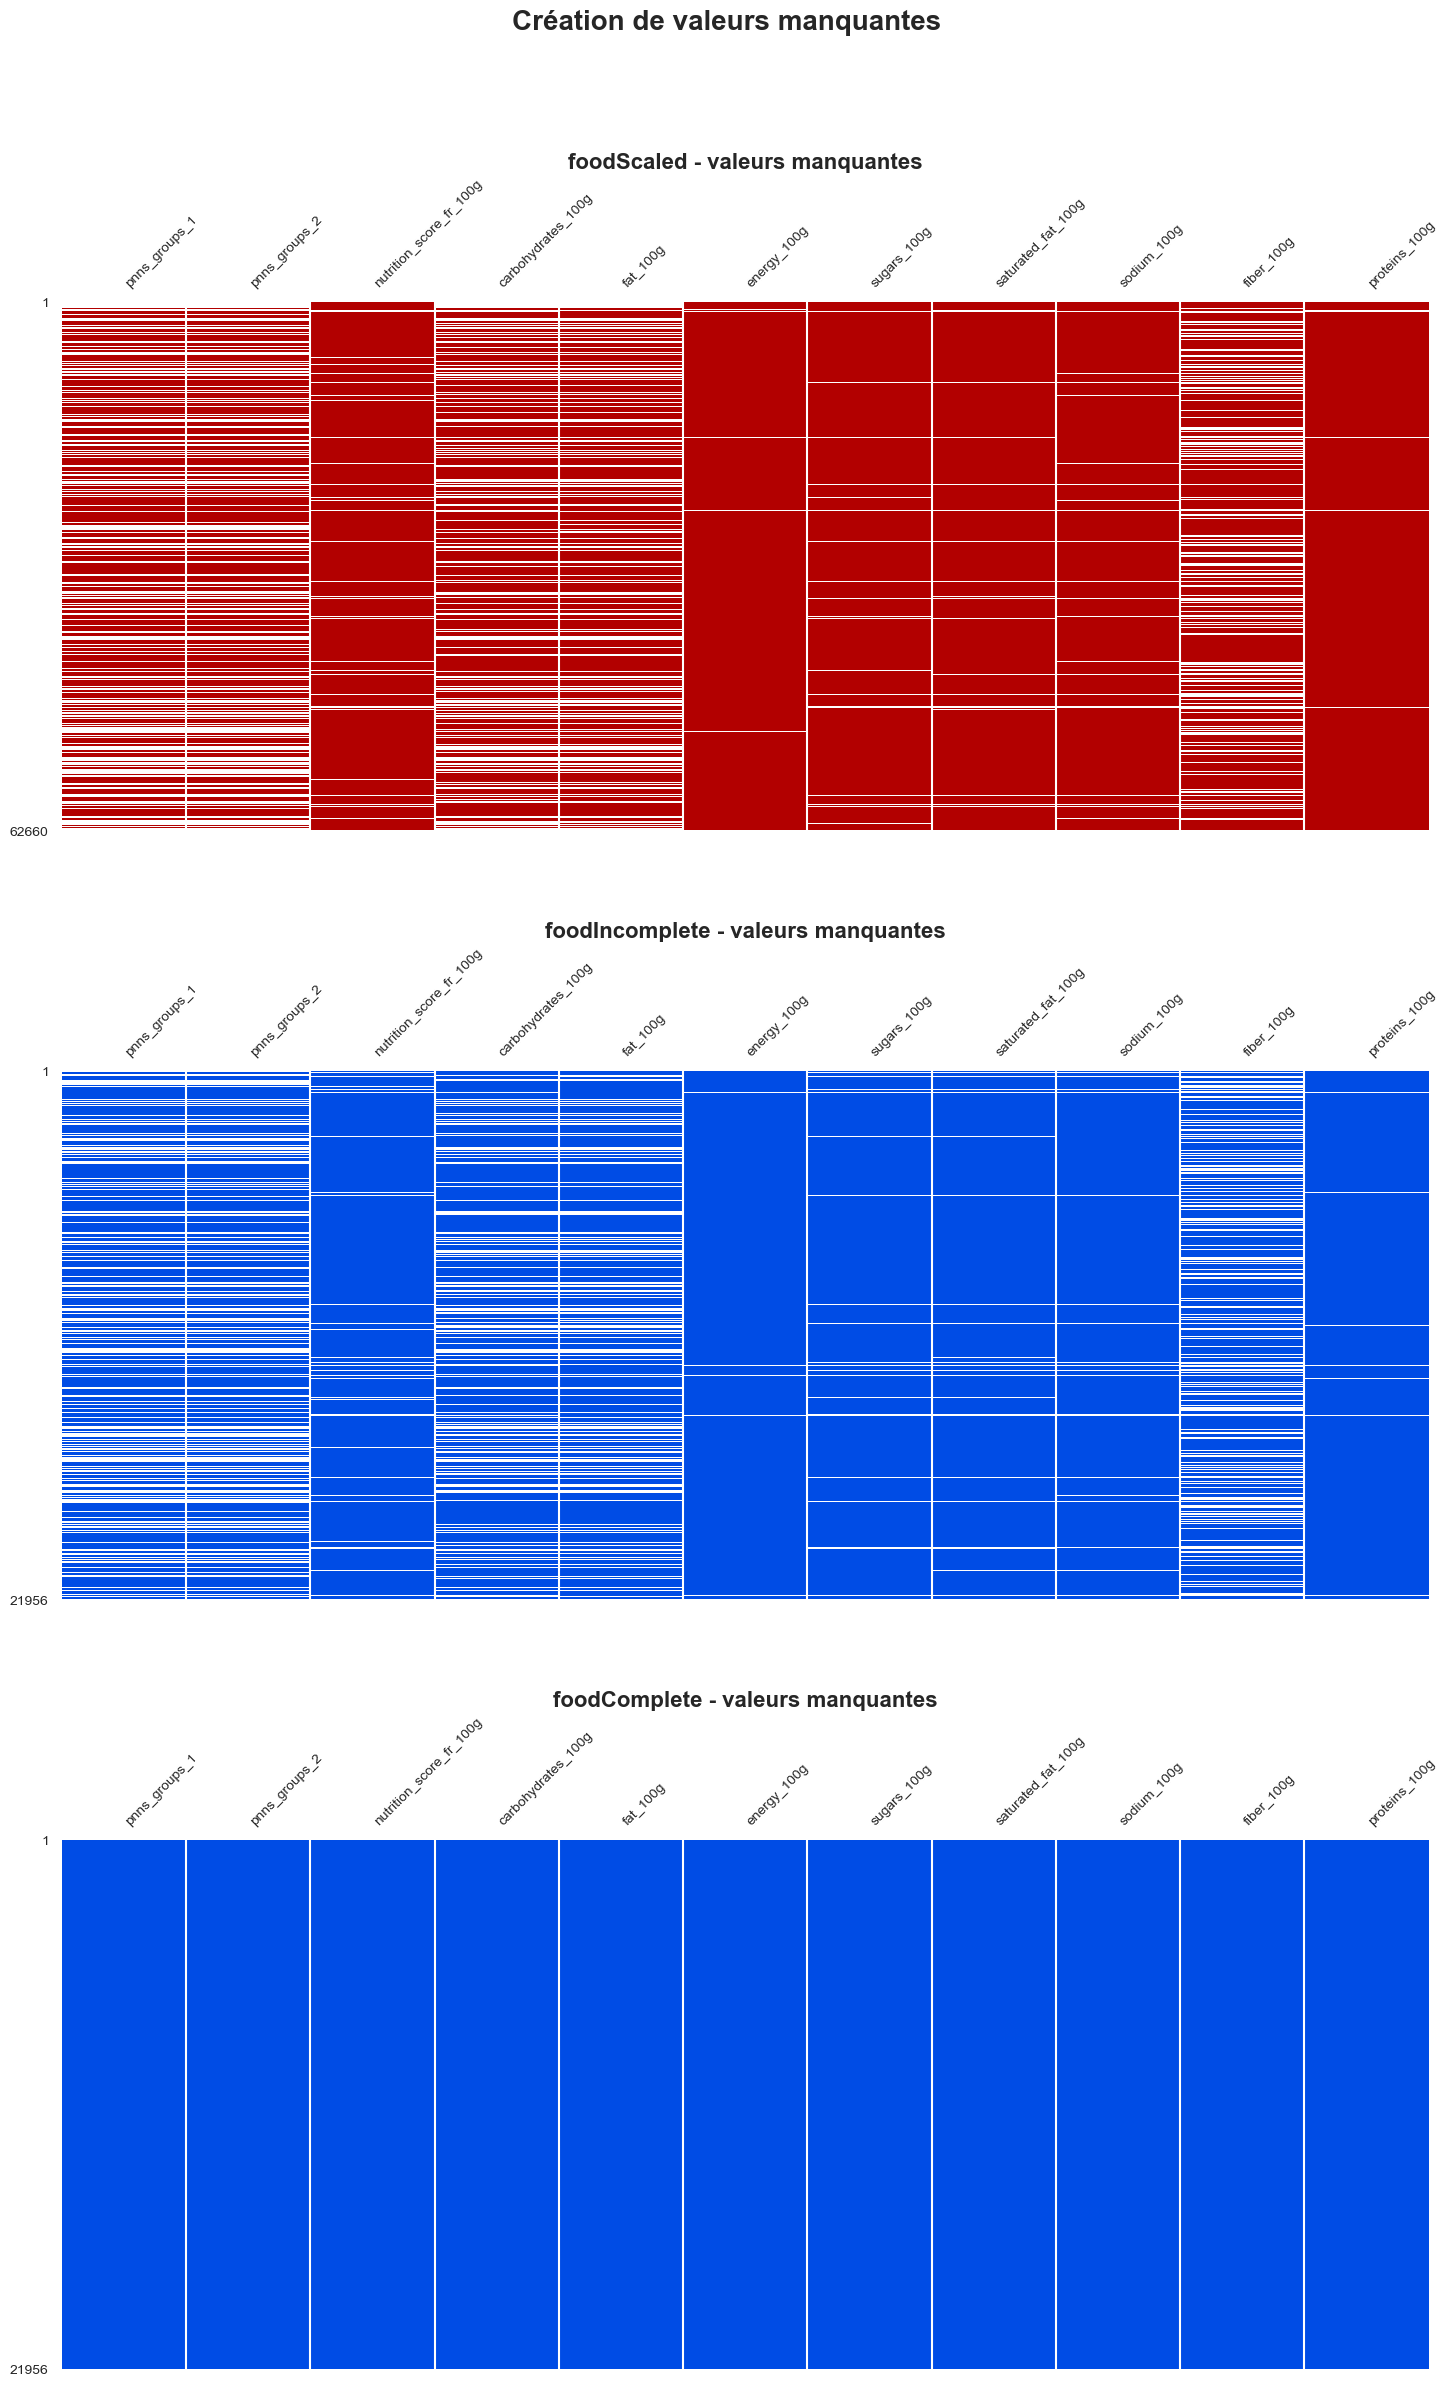

In [95]:
# visualisation of missing values

listOfDf=[foodScaled,foodIncomplete,foodComplete]
listOfDfNames=["foodScaled","foodIncomplete","foodComplete"]
listOfColors=[[0.7,0.0,0.0],[0.0,0.3,0.9],[0.0,0.3,0.9]]

fig,axs=plt.subplots(len(listOfDf),1,figsize=(16,25))
fig.suptitle("Création de valeurs manquantes", fontweight="bold",fontsize=20) # set main title

# dataviz of missing data

for i in range(len(listOfDf)) :
    
    ms.matrix(listOfDf[i],color=listOfColors[i],sparkline=False,ax=axs[i]) 
    axs[i].set_title(listOfDfNames[i]+" - valeurs manquantes", fontweight="bold",fontsize=16) 
    axs[i].set_xticklabels(axs[i].get_xticklabels(),fontsize=10)
    axs[i].set_yticklabels(axs[i].get_yticklabels(),fontsize=10)
    
fig.tight_layout(pad=5.0)

plt.show()

Nous disposons maintenant d'un dataframe `foodIncomplete` avec, pour chaque feature, environ la même proportion de valeurs manquantes que le dataframe original.

`foodIncomplete` nous permettra de réaliser des tests d'imputation.

Le dataframe `foodComplete` contient les valeurs réelles pour ces valeurs manquantes, ce qui nous permettra de vérifier.

### P2.4.4. Imputation des features catégorielles "pnns_groups_1" et "pnns_groups_2"

Pour l'imputation de ces deux variables catégorielles, nous allons utiliser la fonction créée plus haut. Essayons par exemple d'imputer "pnns_groups_1" avec k=3 :

In [96]:
# myKNNCategoricalImputer on "pnns_groups_1" of foodIncomplete, with k=3
pnns1Imp3NN=myKNNCategoricalImputer (foodIncomplete,"pnns_groups_1",k=3)

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

On peut regarder ce que cela donne au niveau du pourcentage d'erreur d'imputation.

In [97]:
# check precision

mask=foodIncomplete.pnns_groups_1.isna()
compare=pd.DataFrame()
compare["soluce"]=foodComplete.loc[mask,"pnns_groups_1"]
compare["imput"]=pnns1Imp3NN.loc[mask,"pnns_groups_1"]

In [98]:
errorPercent=(compare["soluce"]!=compare["imput"]).mean()
errorPercent

0.12652196929592377

Regardons avec un autre k. Par exemple k=8

In [99]:
pnns1Imp8NN=myKNNCategoricalImputer (foodIncomplete,"pnns_groups_1",k=8)

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [100]:
mask=foodIncomplete.pnns_groups_1.isna()
compare=pd.DataFrame()
compare["soluce"]=foodComplete.loc[mask,"pnns_groups_1"]
compare["imput"]=pnns1Imp8NN.loc[mask,"pnns_groups_1"]

In [101]:
errorPercent=(compare["soluce"]!=compare["imput"]).mean()
errorPercent

0.5972736897829539

La précision est moins bonne pour k=8.

Utilisons maintenant la fonction d'optimisation de k pour créée plus haut. Et **déterminons le meilleur k pour chacune** de nos deux "pnns_groups_x" :

In [102]:
# BestKforMyKNNCatImputer on "pnns_groups_1", with test dataframes foodComplete and foodIncomplete
%time errorsForPnns1=BestKforMyKNNCatImputer(foodComplete, foodIncomplete, catCol="pnns_groups_1", rangeOfK=(1,10))

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Wall time: 9.63 s


In [103]:
# BestKforMyKNNCatImputer on "pnns_groups_3", with test dataframes foodComplete and foodIncomplete
%time errorsForPnns2=BestKforMyKNNCatImputer(foodComplete, foodIncomplete, catCol="pnns_groups_2", rangeOfK=(1,10))

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Wall time: 10.1 s


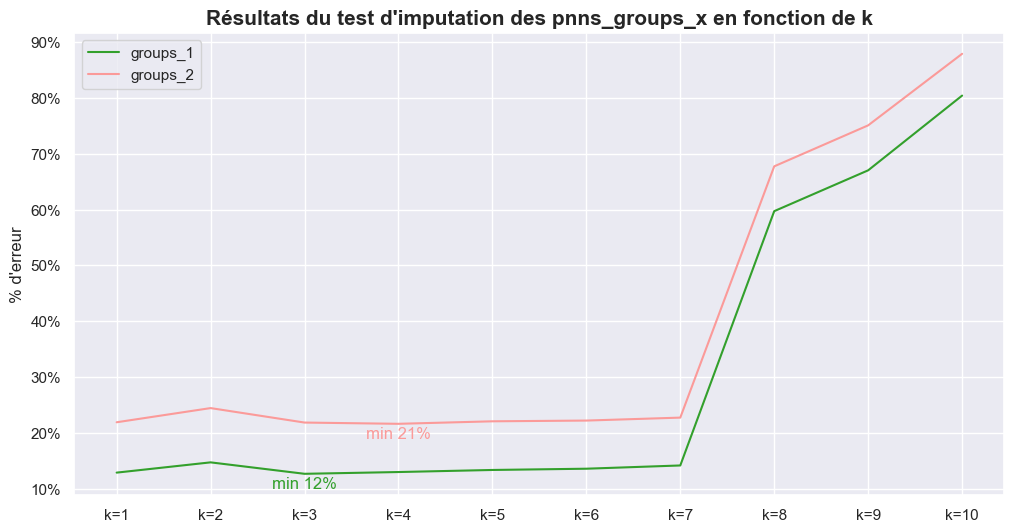

In [104]:
# plot imputation error percentages for different k, for "pnns_groups_1" and "pnns_groups_2" 


errors=pd.concat([errorsForPnns1,errorsForPnns2],axis=1) # put results on an unique tab

fig,axs=plt.subplots(1,figsize=(12,6))

palette=sns.color_palette("Paired") # set color palette

# draw a lineplot for each pnns
for i,catCol in enumerate(errors.columns.tolist()) :
    sns.lineplot(
        data=errors,
        y=errors[catCol],
        x=errors.index.tolist(),
        ax=axs,
        color=palette[i+3],
        label=catCol[catCol.find("g"):]
    )

    # put the best error percentage on each line
    axs.text(
        x=errors[catCol].idxmin(axis=0),
        y=errors[catCol].min()-0.005,
        s="min "+str(int(errors[catCol].min()*100))+"%",
        color=palette[i+3],
        ha="center",
        va="top"
    )
    

axs.set_ylabel("% d'erreur") # set y label
axs.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1)) # use matplotlib.ticker to format y axis as percent
plt.title("Résultats du test d'imputation des pnns_groups_x en fonction de k", fontweight="bold",fontsize=15) # set title


plt.show()


Nous utilisons donc ces paramètres pour imputer nos deux features catégorielles :

In [174]:
%%time
# imput "pnns_groups_1" and "pnns_groups_2" with their best k
foodCatImputed = foodScaled.copy() # create a copy()
for col in errors.columns : # iterate on columns of errors
    bestK=int(errors[col].idxmin()[-1]) # find row with the minimum and keep the value of k
    foodCatImputed = myKNNCategoricalImputer ( # use the categorical imputation function
        foodCatImputed, 
        col.split("_",1)[1], # recover the name "pnns_groups_x" from "%Error_pnns_groups_x"
        k=bestK # use the best k
    )

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Wall time: 10 s


C:\Users\cleme\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


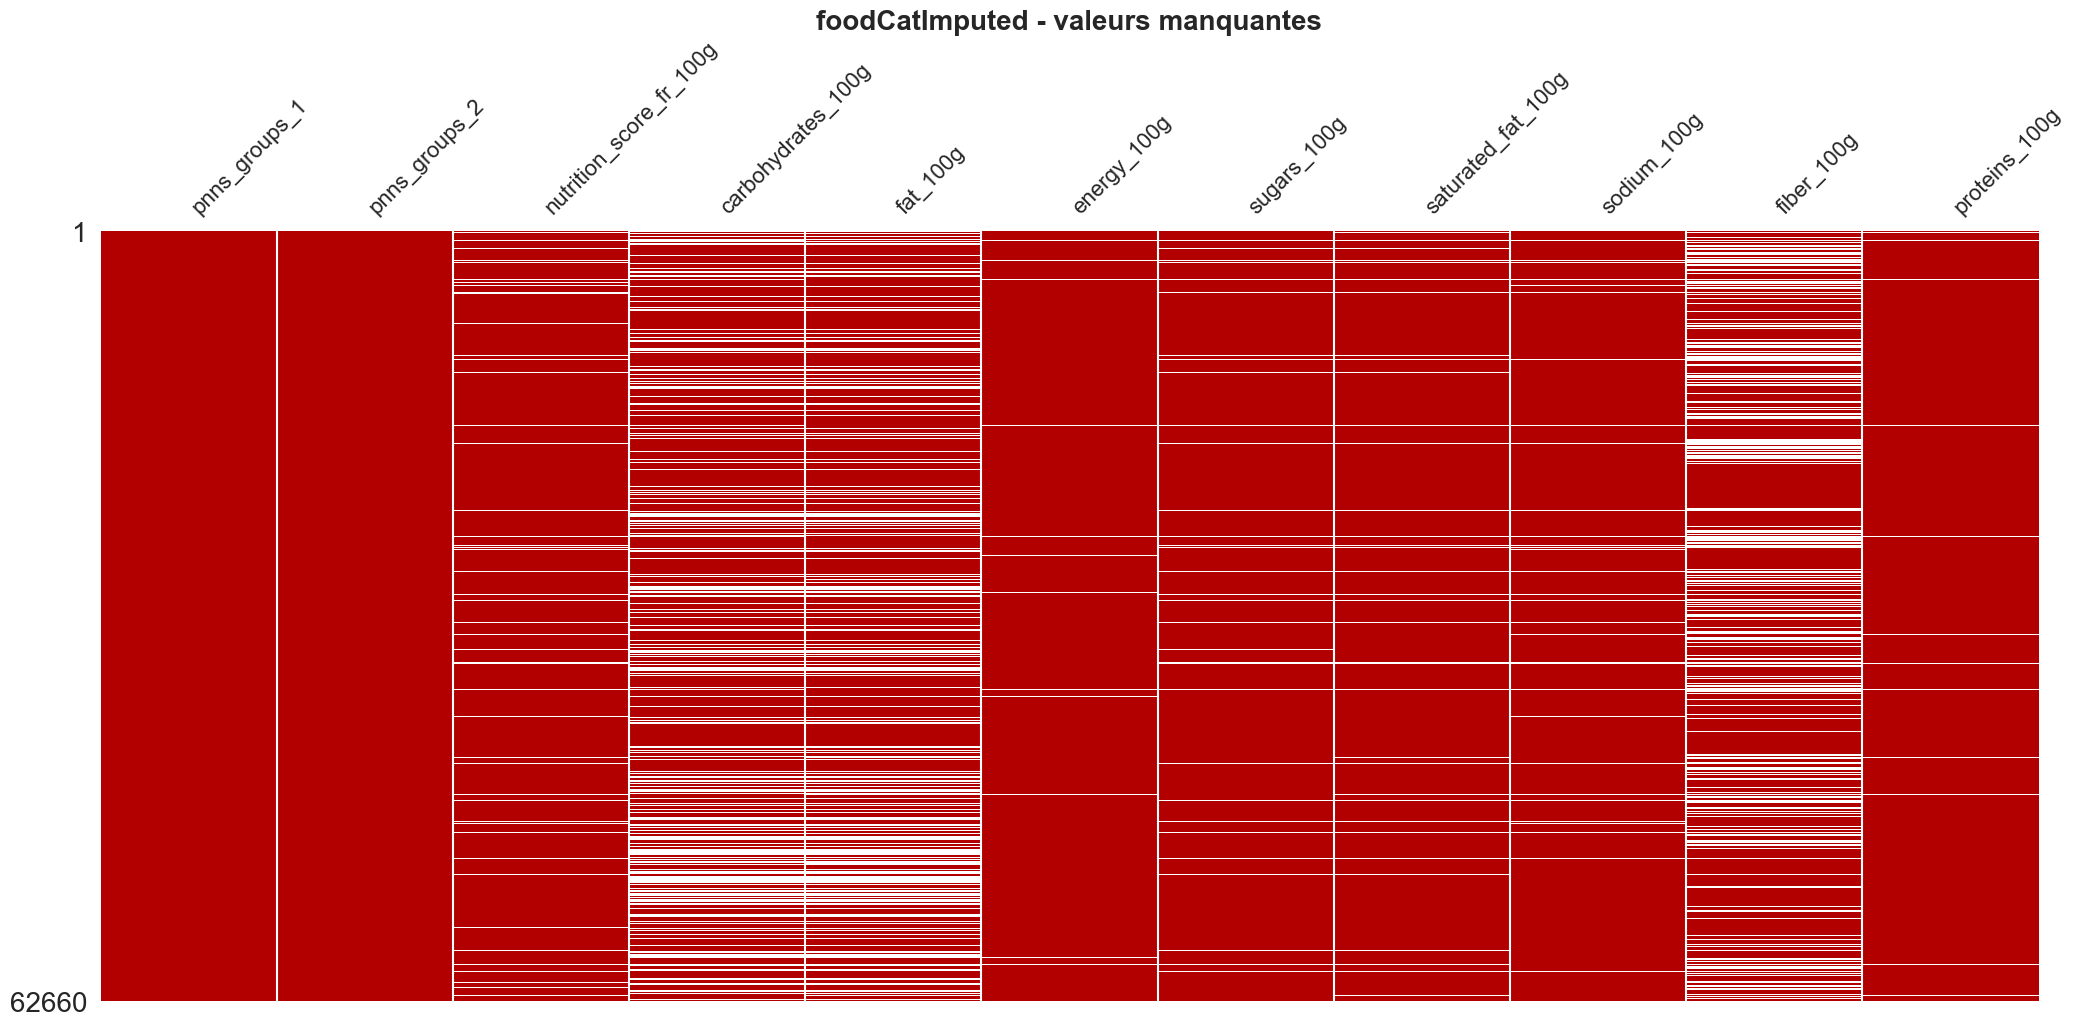

In [175]:
# visualisation of missing values
ms.matrix(foodCatImputed,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("foodCatImputed - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

Mettons également à jour nos dataframes de test :

In [176]:
# Update dataframes to test imputations
%time foodComplete, foodIncomplete = generateDfsToTestImput (foodCatImputed)

Wall time: 9.12 s


### P2.4.5. Imputer les variables numériques. Tests sur la totalité du dataframe

#### P2.4.5.1. Global 5NN

Nous allons tout d'abord tester le KNN Imputeur sur la totalité de nos features numériques.

Essayons **au hasard avec k=5**.
Nous en profiterons pour regarder le **temps d'exécution**.

In [108]:
# KNN pour les autres variables
KNN_imputer = KNNImputer(n_neighbors=5,missing_values=np.nan)
%time foodTestImp01=pd.DataFrame(KNN_imputer.fit_transform(foodIncomplete[foodCompleteNumFeaturesNames]),columns=foodCompleteNumFeaturesNames,index=foodIncomplete.index)

Wall time: 22.3 s


Le temps de calcul est long.

Regardons à quoi ressemble une des features, au hasard "sugars_100g", au niveau des lignes imputées :

In [109]:
sampleSugars_Global5NN=getSoluceColAndGuessCol (
    col="sugars_100g", 
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp01, 
).sample(15,random_state=1)
sampleSugars_Global5NN

,sugars_100g_SOLUCE,sugars_100g_IMPUT
243562,3.0,4.14
233795,0.5,3.88
242859,0.5,0.82
248794,13.7,12.80
188085,4.0,7.72
212471,0.5,4.12
200604,0.2,12.56
270998,18.7,21.24
311352,2.0,1.40
219373,2.8,3.50


Cela n'a pas l'air très concluant, regardons ce que cela donne pour les RMSEs et R2s de chaque feature numérique :

In [110]:
global5NN_measures=resultsNumImput(
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp01
)

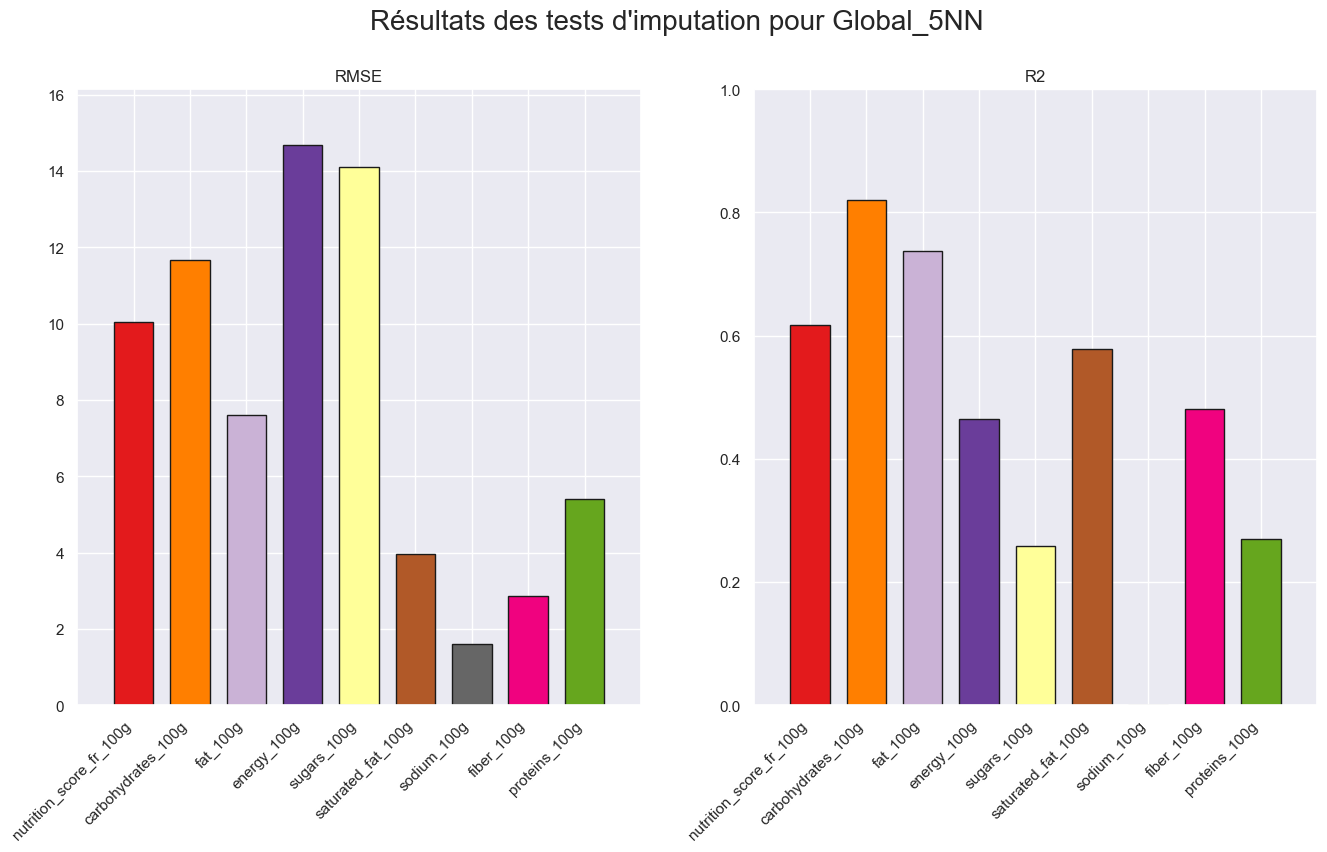

In [111]:
ShowResultsNumImputs (global5NN_measures,"Global_5NN",dictPalette=foodPaletteDict)

#### P2.4.5.2. Global BestNN

Essayons d'optimiser k. Pour cela nous allons créer une fonction qui va :
- itérer sur une fourchette de k donnée
- nous donner en sortie :
    - un tableau avec pour chaque feature numérique, et chaque valeur de k, le RMSE. Ainsi que le meilleur k (celui qui donne le plus petit RMSE).
    - un tableau avec pour chaque feature numérique, et chaque valeur de k, le R2. Ainsi que le meilleur k (celui qui donne le plus grand coefficient de détermination R2).
    - un tableau avec la moyenne des RMSEs et R2s, pour chaque valeur de k. Ainsi que le meilleur k en considérant ces moyennes.

In [112]:
def BestKNNImputer(dfComplete, dfIncomplete, rangeOfK=(2,10)) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfGuess : same dataframe, with the missing values imputed
    
    optional parameters
    -------------------
    nameOfTest : string, name of the imputation test
    
    returns
    -------
    resultTab : dataframe with
        numerical features in index 
        a column with RMSE 
        a column with R2
    '''
    
    # list of numerical features
    numFeaturesNames = dfComplete.select_dtypes("float64").columns.tolist()
    
    # create dataframes to store the mesures for each k
    resultTabRMSE=pd.DataFrame(index=numFeaturesNames,dtype="float64")
    resultTabR2=pd.DataFrame(index=numFeaturesNames,dtype="float64")
    
    # create a dataframe to store the mean of RMSEs and the mean of R2s for each k
    resultTabGlobal=pd.DataFrame(columns=["k="+str(i) for i in range(rangeOfK[0],rangeOfK[1]+1)], 
                                 index=["Mean_of_RMSEs","Mean_of_R2s"],dtype="float64")
    
    for k in range(rangeOfK[0],rangeOfK[1]+1) :
        
        KNN_imputer=KNNImputer(n_neighbors=k,missing_values=np.nan) # initiate knn imputer for this k
        
        # generate a dfGuess
        dfImputK=pd.DataFrame(
            KNN_imputer.fit_transform(dfIncomplete[numFeaturesNames]), # fit transform
            columns=numFeaturesNames,
            index=dfIncomplete.index
        )
        
        # use previous function and generate a resultsNumImput(dfComplete, dfIncomplete, dfImput) :
        resultTabK=resultsNumImput(
            dfComplete=dfComplete, 
            dfIncomplete=dfIncomplete, 
            dfImput=dfImputK, 
        )
        
        # put in the main tabs
        resultTabRMSE["RMSE"+"_"+"k="+str(k)]=resultTabK["RMSE"]
        resultTabR2["R2"+"_"+"k="+str(k)]=resultTabK["R2"]
        
       
        resultTabGlobal["k="+str(k)].loc["Mean_of_RMSEs"]=resultTabK["RMSE"].mean()
        resultTabGlobal["k="+str(k)].loc["Mean_of_R2s"]=resultTabK["R2"].mean()
    
    # give for each numerical feature the k with best RMSE and R2
    resultTabRMSE["best_k_per_feature"]=resultTabRMSE.idxmin(axis=1).str.split("=").str[-1]
    resultTabR2["best_k_per_feature"]=resultTabR2.idxmax(axis=1).str.split("=").str[-1]
    
    # give, globally, for Mean_of_RMSEs and for Mean_of_R2s, the best k
    resultTabGlobal.loc["Mean_of_RMSEs","best_k_on_average"]=resultTabGlobal.loc["Mean_of_RMSEs"].idxmin(axis=0).split("=")[-1]
    resultTabGlobal.loc["Mean_of_R2s","best_k_on_average"]=resultTabGlobal.loc["Mean_of_R2s"].astype("float64").idxmax(axis=0).split("=")[-1]
  
    return resultTabRMSE,resultTabR2,resultTabGlobal

Regardons l'impact de k sur la précision de l'imputation, pour **k de 2 à 15** :

In [113]:
%time tabRMSE,tabR2,tabMean = BestKNNImputer(dfComplete=foodComplete, dfIncomplete=foodIncomplete, rangeOfK=(2,15))

Wall time: 5min 12s


In [114]:
display(tabRMSE,tabR2,tabMean)

,RMSE_k=2,RMSE_k=3,RMSE_k=4,RMSE_k=5,RMSE_k=6,RMSE_k=7,RMSE_k=8,RMSE_k=9,RMSE_k=10,RMSE_k=11,RMSE_k=12,RMSE_k=13,RMSE_k=14,RMSE_k=15,best_k_per_feature
nutrition_score_fr_100g,11.794787,10.812869,10.451485,10.054391,9.924545,9.721459,9.626713,9.523962,9.478449,9.444034,9.356850,9.339510,9.308569,9.298754,15
carbohydrates_100g,15.072360,13.265429,12.339786,11.678373,11.279747,10.934585,10.755992,10.592556,10.526604,10.317693,10.180712,10.092205,10.037541,9.950687,15
fat_100g,11.077761,9.492107,8.479094,7.611682,6.978727,6.551512,6.345036,6.020919,5.806663,5.634318,5.458058,5.323678,5.222840,5.134739,15
energy_100g,16.962993,16.436767,14.618349,14.680965,14.487819,14.170564,14.140325,14.111533,14.067607,13.906120,13.814173,13.812983,13.753909,13.751900,15
sugars_100g,15.611195,14.667858,14.280024,14.103236,13.507787,13.042142,12.717532,12.776579,12.802094,12.594818,12.330224,12.246037,12.085316,12.008090,15
saturated_fat_100g,4.547810,4.080858,3.970454,3.956323,3.957056,3.938604,3.932071,3.886237,3.904602,3.881895,3.842327,3.818490,3.848289,3.841518,13
sodium_100g,1.655496,1.615885,1.603114,1.600108,1.599036,1.594492,1.591452,1.592446,1.592990,1.595113,1.595222,1.607698,1.602813,1.600949,8
fiber_100g,3.066938,2.907386,2.855245,2.848320,2.829609,2.823772,2.805361,2.812692,2.801396,2.797981,2.813269,2.814619,2.821947,2.826609,11
proteins_100g,6.184021,5.905993,5.355532,5.396886,5.367942,5.291947,5.260178,5.247346,5.288323,5.236700,5.294044,5.269164,5.255506,5.220910,15


,R2_k=2,R2_k=3,R2_k=4,R2_k=5,R2_k=6,R2_k=7,R2_k=8,R2_k=9,R2_k=10,R2_k=11,R2_k=12,R2_k=13,R2_k=14,R2_k=15,best_k_per_feature
nutrition_score_fr_100g,0.473025,0.557114,0.586223,0.617068,0.626895,0.642008,0.648952,0.656406,0.659682,0.662149,0.668358,0.669586,0.671772,0.672463,15
carbohydrates_100g,0.700803,0.768241,0.799456,0.820378,0.832431,0.842530,0.847631,0.852227,0.854061,0.859796,0.863494,0.865858,0.867307,0.869593,15
fat_100g,0.444289,0.591990,0.674430,0.737635,0.779455,0.805630,0.817689,0.835839,0.847314,0.856243,0.865097,0.871658,0.876474,0.880606,15
energy_100g,0.285260,0.328917,0.469189,0.464632,0.478626,0.501210,0.503337,0.505357,0.508432,0.519653,0.525984,0.526066,0.530111,0.530248,15
sugars_100g,0.091086,0.197613,0.239484,0.258198,0.319514,0.365621,0.396807,0.391193,0.388759,0.408391,0.432988,0.440704,0.455288,0.462228,15
saturated_fat_100g,0.442855,0.551392,0.575337,0.578354,0.578198,0.582123,0.583508,0.593161,0.589307,0.594070,0.602303,0.607222,0.601068,0.602470,13
sodium_100g,-0.072090,-0.021401,-0.005319,-0.001553,-0.000210,0.005465,0.009254,0.008017,0.007338,0.004691,0.004555,-0.011077,-0.004941,-0.002605,8
fiber_100g,0.398554,0.459504,0.478717,0.481242,0.488035,0.490145,0.496772,0.494139,0.498194,0.499416,0.493931,0.493445,0.490804,0.489120,11
proteins_100g,0.040842,0.125149,0.280629,0.269476,0.277291,0.297609,0.306017,0.309399,0.298571,0.312198,0.297052,0.303644,0.307249,0.316339,15


,k=2,k=3,k=4,k=5,k=6,k=7,k=8,k=9,k=10,k=11,k=12,k=13,k=14,k=15,best_k_on_average
Mean_of_RMSEs,9.552596,8.798350,8.217009,7.992254,7.770252,7.563231,7.463851,7.396030,7.363192,7.267630,7.187209,7.147154,7.104081,7.070462,15
Mean_of_R2s,0.311625,0.395391,0.455349,0.469492,0.486693,0.503594,0.512219,0.516193,0.516851,0.524067,0.528196,0.529678,0.532792,0.535607,15


On voit que modifier k n'a pas beaucoup d'impact sur la précision de l'imputation. De plus le temps de calcul est **très (très) long**.

#### P2.4.5.3. Global Iterative Imputer

Essayons l'Iterative Imputer :

In [115]:
# iterative imputeur on all numerical features
from sklearn.linear_model import LinearRegression
iterative_imputer = IterativeImputer(estimator=LinearRegression())
%time foodTestImp02=pd.DataFrame(iterative_imputer.fit_transform(foodIncomplete[foodCompleteNumFeaturesNames]),columns=foodCompleteNumFeaturesNames,index=foodIncomplete.index)

Wall time: 681 ms


C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


L'Iterative Imputer est bien plus rapide. Regardons ce que cela donne avec "sugars_100g" :

In [116]:
sampleSugars_GlobalIterImp=getSoluceColAndGuessCol (
    col="sugars_100g", 
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp02, 
).sample(15,random_state=1)
sampleSugars_GlobalIterImp

,sugars_100g_SOLUCE,sugars_100g_IMPUT
243562,3.0,6.670629
233795,0.5,12.375964
242859,0.5,0.880297
248794,13.7,8.584510
188085,4.0,5.517163
212471,0.5,12.702665
200604,0.2,27.689537
270998,18.7,20.347766
311352,2.0,3.221183
219373,2.8,13.234916


Cela n'a pas l'air beaucoup mieux. Regardons ce que cela donne pour le RMSE et R2 :

In [117]:
globalIterImp_measures=resultsNumImput(
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp02
)

In [118]:
foodMeasuresTabs=[
    global5NN_measures,
    globalIterImp_measures
]
foodTestNames=[
    "Global_5NN",
    "Global_IterativeImputer"
]

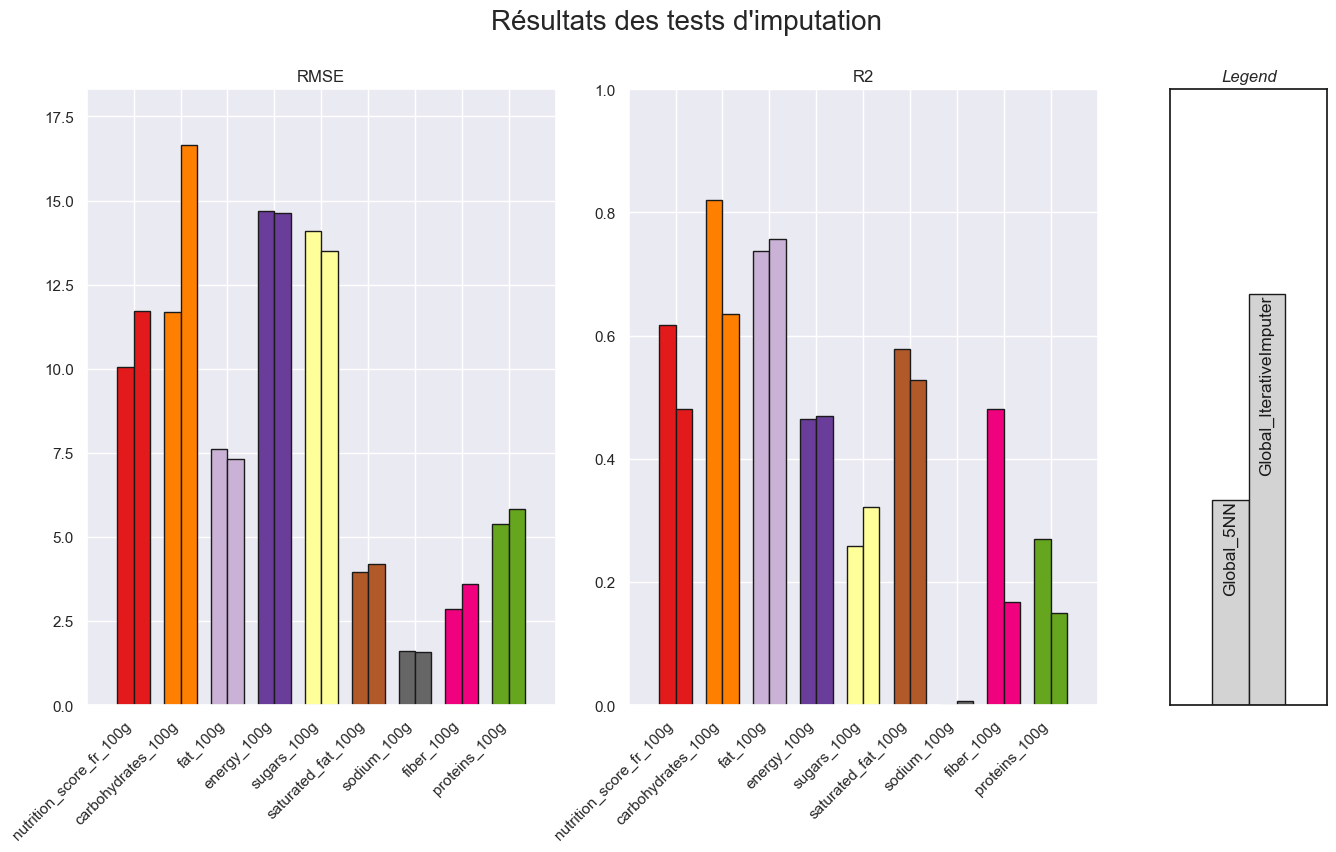

In [119]:
ShowResultsNumImputs (foodMeasuresTabs,foodTestNames,dictPalette=foodPaletteDict)

Le temps de calcul est donc bien meilleur, mais nous obtenons des résultats moins bons...

Cela peut s'expliquer : l'IterativeImputer impute en réalisant une regression (ici, linéaire) de **chaque feature en fonction de TOUTES les autres, à tour de rôle**. Or toutes nos features **ne sont pas correlés entre elles**...

**Une solution pour améliorer** nos imputations serait :
- d'**étudier les corrélations entre features** 
    
    Ainsi nous pourrons utiliser l'IterativeImputer, bien plus rapide, à **bon escient**.
    
    
- de filtrer par **modalité de pnns_1** pour étudier des produits de la même grande famille.

    L'utilisation de "pnns_groups_1" plutôt que "pnns_groups_2" est un choix :
   - l'imputeur catégoriel a eu de meilleurs résultats
   - le nombre de catégories de "pnns_groups_2" est très (trop ?) grand pour pouvoir bénéficier de suffisemment de produits pour l'IterativeImputer.

### P2.4.6. Améliorer nos imputations

#### P2.4.6.1. Matrice des corrélations

Calculons tout d'abord notre matrice des correlations :

In [120]:
# Compute the correlation matrix
foodCorr=foodCatImputed.loc[~foodCatImputed.isna().all(axis=1)].corr()
foodCorr

,nutrition_score_fr_100g,carbohydrates_100g,fat_100g,energy_100g,sugars_100g,saturated_fat_100g,sodium_100g,fiber_100g,proteins_100g
nutrition_score_fr_100g,1.000000,0.243538,0.579531,0.625728,0.451424,0.603513,0.121645,-0.127557,0.097078
carbohydrates_100g,0.243538,1.000000,-0.071361,0.527415,0.636864,-0.024774,-0.080776,0.250487,-0.131873
fat_100g,0.579531,-0.071361,1.000000,0.782006,0.005597,0.744111,0.009715,0.081547,0.145883
energy_100g,0.625728,0.527415,0.782006,1.000000,0.327639,0.572878,-0.023889,0.210181,0.209382
sugars_100g,0.451424,0.636864,0.005597,0.327639,1.000000,0.080296,-0.086722,0.034818,-0.249965
saturated_fat_100g,0.603513,-0.024774,0.744111,0.572878,0.080296,1.000000,0.008070,0.019908,0.143507
sodium_100g,0.121645,-0.080776,0.009715,-0.023889,-0.086722,0.008070,1.000000,0.004599,0.089197
fiber_100g,-0.127557,0.250487,0.081547,0.210181,0.034818,0.019908,0.004599,1.000000,0.197247
proteins_100g,0.097078,-0.131873,0.145883,0.209382,-0.249965,0.143507,0.089197,0.197247,1.000000


Afin d'améliorer la lisibilité, nous allons afficher cette même matrice sur une heatmap en utilisant la librairie Seaborn.
La matrice étant symétrique, nous allons afficher seulement le "triangle" inférieure.

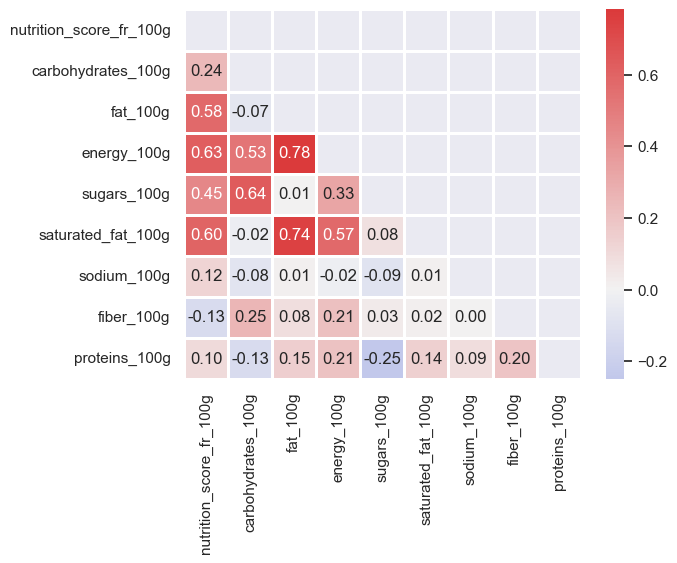

In [121]:
# Display the correlation matrix on a heatmap

# Generate a mask to display only the lower triangle
maskTri = np.triu(np.ones_like(foodCorr, dtype=bool),k=0)

# Draw the heatmap with the mask

sns.heatmap(
    data=foodCorr, # use the correlation matrix computed above
    mask=maskTri, # mask to display only the low triangle
    linewidth=1, # line between squares of the heatmap
    cmap=sns.diverging_palette(262,12, as_cmap=True,center="light",n=9), # blue for anticorrelated, red for correlated
    center=0, # no color for no correlation
    annot=True, # displays Pearson coefficients
    fmt="0.2f" # with 2 decimals
);

Les paires suivantes sont correlées avec un niveau supérieur à 0.60 :
- "fat_100g", "energy_100g"
- "fat_100g", "saturated_fat_100g"
- "sugars_100g", "carbohydrates_100g"
- "energy_100g", "nutrition_score_fr_100g"
- "saturated_fat_100g", "nutrition_score_fr_100g"

On peut donc faire des groupes de features pour nos opérations d'imputation avec l'IterativeImputer.

#### P2.4.6.2. Groupes d'imputation - impact de "pnns_1" ?

Nous allons tester la fonction créée plus haut. Tout d'abord sur la totalité du dataframe :

In [122]:
IterImpGroups = makeCorrGroups(foodCatImputed, threshold=0.6)
IterImpGroups

{'G1': ['nutrition_score_fr_100g', 'energy_100g', 'saturated_fat_100g'],
 'G2': ['carbohydrates_100g', 'sugars_100g'],
 'G3': ['fat_100g', 'energy_100g', 'saturated_fat_100g'],
 'others': ['sodium_100g', 'fiber_100g', 'proteins_100g']}

In [123]:
foodCatImputed.pnns_groups_1.unique().tolist()

['Sugary snacks',
 'Cereals and potatoes',
 'Beverages',
 'Composite foods',
 'Fruits and vegetables',
 'Fish meat eggs',
 'Milk and dairy products',
 'Salty snacks',
 'Fat and sauces']

Testons maintenant sur deux catégorie différentes de "pnns_groups_1". Au hasard `Beverages` et `Salty snacks`. 

In [124]:
makeCorrGroups(foodCatImputed.loc[foodCatImputed.pnns_groups_1=='Sugary snacks'], threshold=0.6)

{'G1': ['nutrition_score_fr_100g',
  'fat_100g',
  'energy_100g',
  'saturated_fat_100g'],
 'others': ['carbohydrates_100g',
  'sugars_100g',
  'sodium_100g',
  'fiber_100g',
  'proteins_100g']}

In [125]:
makeCorrGroups(foodCatImputed.loc[foodCatImputed.pnns_groups_1=='Cereals and potatoes'], threshold=0.6)

{'G1': ['nutrition_score_fr_100g', 'saturated_fat_100g'],
 'G2': ['carbohydrates_100g', 'energy_100g'],
 'G3': ['fat_100g', 'saturated_fat_100g'],
 'others': ['sugars_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g']}

In [126]:
makeCorrGroups(foodCatImputed.loc[foodCatImputed.pnns_groups_1=="Salty snacks"], threshold=0.6)

{'G1': ['fat_100g', 'energy_100g'],
 'others': ['nutrition_score_fr_100g',
  'carbohydrates_100g',
  'sugars_100g',
  'saturated_fat_100g',
  'sodium_100g',
  'fiber_100g',
  'proteins_100g']}

Les groupes sont donc bien différents. Nous utiliserons donc "pnns_groups_1" comme filtre préalable à la création des groupes.

#### P2.4.6.3. Imputation des valeurs manquantes par groupe de features correlées

Nous allons réaliser nos imputations par catégoire de "pnns_groups_1". Pour chaque catégorie :
- nous **rechercherons les groupes** basés sur la corrélation entre features
- par groupe, nous réalisons nos imputations des valeurs manquantes :
    - pour les groupes avec de la correlation : nous imputons les valeurs manquantes avec un **`IterativeImputer` sur le groupe en question**
    - pour le groupe **`others`** : nous imputons les valeurs manquantes avec un **`4NNImputer`** entraîné sur **la totalité des features**, en ne gardant **que les features "others" à la fin**
-  dans le cas où **une feature** serait **présente dans plusieurs groupes** :
    - on compare le **RMSE**
    - on **conserve la meilleure** version
    - on **note** la catégorie de "pnns_groups_1" et le groupe concernés

Le choix de 4NN est dû au fait :
- que le groupe `others` semble souvent comporter 'sodium_100g', 'fiber_100g', 'proteins_100g'.
- lors du test, non concluant, d'optimisation de k pour le KNN Global, k=4 était un bon paramètre pour ces features.


In [177]:

foodTestImp03 = foodIncomplete.copy()

# create a list of "pnns_groups_1" categories
pnns_groups_1_Uniques=foodIncomplete.pnns_groups_1.unique().tolist()

# create a dictionnary to store the name of selected group when a same column is in two groups
dictOfColumns = {col : [] for col in foodIncomplete.select_dtypes("float64").columns}
dictBestGroupForEachCat1 = {cat1 : dictOfColumns.copy() 
                            for cat1 in pnns_groups_1_Uniques 
                            }

# iterate on categories of "pnns_groups_1"

for icat1,cat1 in enumerate(pnns_groups_1_Uniques) :
    
    cat1Df = foodIncomplete.loc[foodIncomplete.pnns_groups_1==cat1].copy()
    cat1DfSoluce = foodComplete.loc[foodComplete.pnns_groups_1==cat1].copy()
    
    # create imputation groups for this category
    IterImpGroupsCat1=makeCorrGroups(cat1Df,threshold=0.6)
    imputGroupList=[] # initiate a list to store imputation results for each group of imputation
    
    # impute each feature of a group
    for key,group in IterImpGroupsCat1.items() : # iterate on each group
        
        if key != "others" : # for correlated features groups, we use IterativeImputer
            # imput each group features
            imp=IterativeImputer(estimator=LinearRegression()) # initiate an IterativeImputer
            groupImpCat1 = pd.DataFrame(
                imp.fit_transform(cat1Df[group]), # create a dataframe with imputed features for this group
                columns=group,
                index=cat1Df.index)
            
        else : # for "others", with no correlations, we use a 4NN imputer, on all features, and we keep the "others" columns
            imp=KNNImputer(n_neighbors=4,missing_values=np.nan) # initiate a 4NN Imputer 
            groupImpCat1 = pd.DataFrame(
                imp.fit_transform(cat1Df.select_dtypes("float64")),
                columns=cat1Df.select_dtypes("float64").columns,
                index=cat1Df.index
            )[group]
        
        imputGroupList.append(groupImpCat1) # add this "cat1Df imputed" to the list
            
    # for features in several groups, take the best (best RMSE) and store the information
        
    for i,dfi in enumerate(imputGroupList) :
        for j,dfj in enumerate(imputGroupList) :
            if j<=i :
                continue
            for coli in dfi.columns.tolist() :
                for colj in dfj.columns.tolist() :
                    if coli == colj :
                        RMSEi=np.sqrt(mean_squared_error(cat1DfSoluce[coli],dfi[coli]))
                        RMSEj=np.sqrt(mean_squared_error(cat1DfSoluce[colj],dfj[colj]))
                        if RMSEi < RMSEj :
                            dfj.pop(colj)
                            dictBestGroupForEachCat1[cat1][coli]=dictBestGroupForEachCat1[cat1][coli]+["i"+list(IterImpGroupsCat1.keys())[i]]

                        else :
                            dfi.pop(coli)
                            dictBestGroupForEachCat1[cat1][colj]=dictBestGroupForEachCat1[cat1][colj]+["j"+list(IterImpGroupsCat1.keys())[j]]

                        
    # put result foodTestImp03
    for df in imputGroupList :
        foodTestImp03.loc[cat1Df.index,df.columns.tolist()]=df
    


C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not 

In [178]:
sampleSugars_FocusIterImp=getSoluceColAndGuessCol (
    col="sugars_100g", 
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp03, 
).sample(15,random_state=1)
sampleSugars_FocusIterImp

,sugars_100g_SOLUCE,sugars_100g_IMPUT
243562,3.0,4.100000
233795,0.5,1.875000
242859,0.5,0.800000
248794,13.7,10.334042
188085,4.0,1.800000
212471,0.5,1.550000
200604,0.2,19.325000
270998,18.7,7.740672
311352,2.0,2.254487
219373,2.8,2.100000


Cela n'a pas l'air beaucoup mieux. Regardons ce que cela donne pour le RMSE et R2 :

In [179]:
focusIterImp_measures=resultsNumImput(
    dfComplete=foodComplete, 
    dfIncomplete=foodIncomplete, 
    dfImput=foodTestImp03
)

In [180]:
foodMeasuresTabs=[
    global5NN_measures,
    globalIterImp_measures,
    focusIterImp_measures
]
foodTestNames=[
    "Global_5NN",
    "Global_IterativeImputer",
    "Focus_IterativeImputer"
]

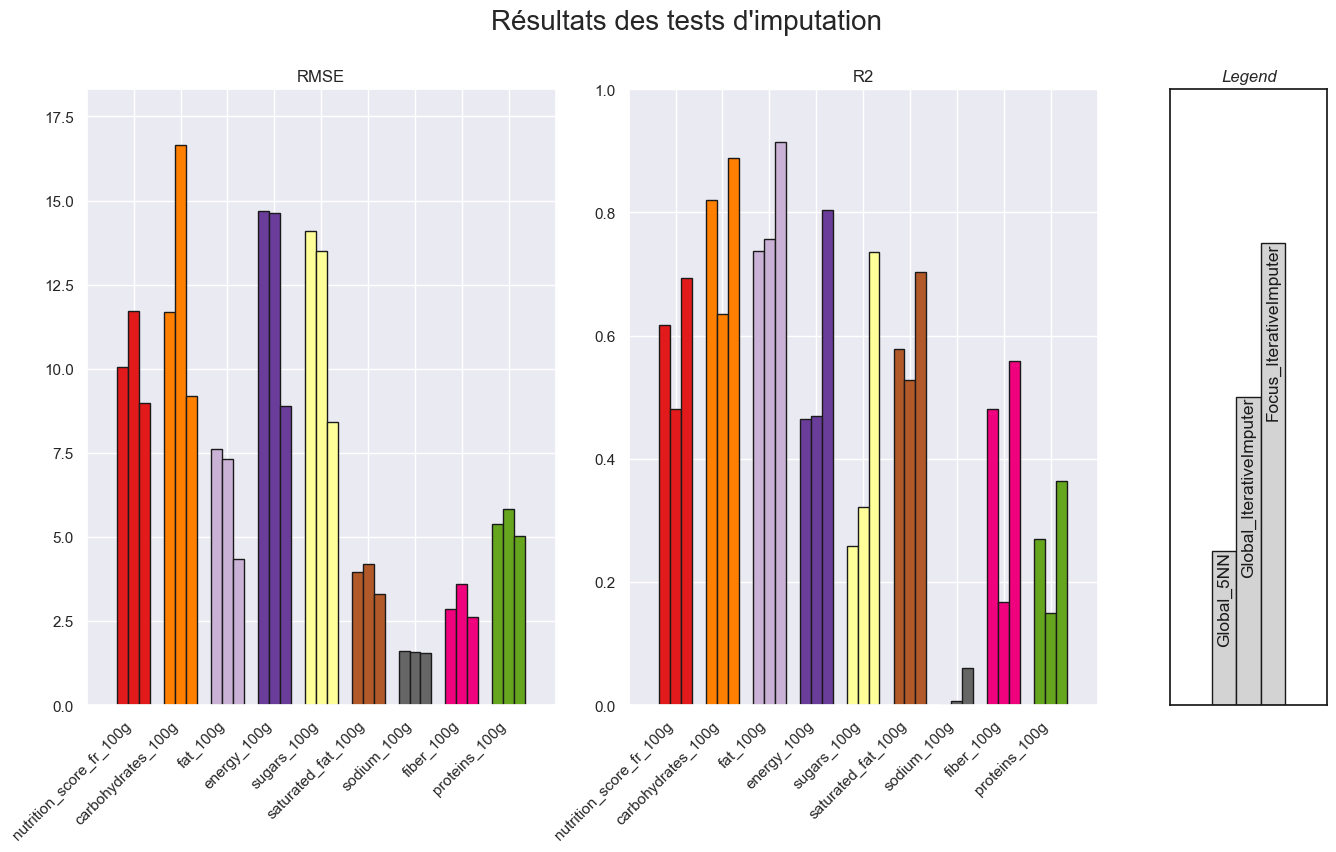

In [181]:
ShowResultsNumImputs (foodMeasuresTabs,foodTestNames,dictPalette=foodPaletteDict)

Ce dernier test est le meilleur des trois tests menés.

Nous décidons donc d'appliquer cette méthode d'imputation sur notre dataframe.

### P2.4.7. Imputation finale des variables numériques

Nous allons utiliser la même méthode pour imputer notre dataframe de travail.

Nous avons conservé en mémoire quels étaient les meilleures versions de colonnes imputées lorsqu'une même colonne était dans plusieurs groupes d'imputation.

Exemple avec la catégorie `'Composite foods'` de "pnns_groups_1" :

In [183]:
dictBestGroupForEachCat1['Composite foods']

{'nutrition_score_fr_100g': [],
 'carbohydrates_100g': [],
 'fat_100g': [],
 'energy_100g': ['iG1', 'jG3'],
 'sugars_100g': [],
 'saturated_fat_100g': ['jG3'],
 'sodium_100g': [],
 'fiber_100g': [],
 'proteins_100g': []}

Lors de l'imputation du dataframe de travail, nous ne pourrons pas comparer avec un `foodComplete`... Par conséquent, dans le cas où une feature serait présente dans 2 groupes d'imputation, nous utiliserons les informations ci-dessus pour conserver la même version imputée que lors du test.

In [184]:
# imputation of out dataframe foodScaled

foodScaledImputed=foodCatImputed.copy() # create a copy()

for cat1 in pnns_groups_1_Uniques : # filter on each "pnns_groups_1" categories
    
    cat1Df = foodCatImputed.loc[foodCatImputed.pnns_groups_1==cat1].copy()
    
    # create imputation groups for this cat1 category
    IterImpGroupsCat1=makeCorrGroups(cat1Df,threshold=0.6)
    
    # initiate a list to store imputation results for each group of imputation
    imputGroupList=[] 
    
    # impute each feature of an imputation group
    
    for key,group in IterImpGroupsCat1.items() : # iterate on each imputation group
        
        if key != "others" : # for correlated features groups, we use IterativeImputer
            # imput each group features
            imp=IterativeImputer(estimator=LinearRegression()) # initiate an IterativeImputer
            groupImpCat1 = pd.DataFrame(
                imp.fit_transform(cat1Df[group]), # create a dataframe with imputed features for this group
                columns=group,
                index=cat1Df.index)
            
        else : # for "others", with no correlations, we use a 4NN imputer, on ALL features, and we keep only the "others" columns
            imp=KNNImputer(n_neighbors=4,missing_values=np.nan) # initiate a 4NN Imputer 
            groupImpCat1 = pd.DataFrame(
                imp.fit_transform(cat1Df.select_dtypes("float64")),
                columns=cat1Df.select_dtypes("float64").columns,
                index=cat1Df.index
            )[group] # keep only "others" features
        
        imputGroupList.append(groupImpCat1) # add this "cat1Df imputed" to the list
            
    # for features in several groups, check previous dictBestGroupForEachCat1 and keep the same
        
    for i,dfi in enumerate(imputGroupList) :
        for j,dfj in enumerate(imputGroupList) :
            if j<=i :
                continue
            for coli in dfi.columns.tolist() :
                for colj in dfj.columns.tolist() :
                    if coli == colj :
                        if "iG"+str(i+1) in dictBestGroupForEachCat1[cat1][coli] :
                            dfj.pop(colj)

                        elif "jG"+str(j+1) in dictBestGroupForEachCat1[cat1][coli] :
                            dfi.pop(coli)


    # put result foodTestImp03
    for df in imputGroupList :
        foodScaledImputed.loc[cat1Df.index,df.columns.tolist()]=df
    


C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\cleme\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not 

Maintenant que notre dataframe ne comporte plus de valeurs manquantes, nous pouvons **inverser la mise à l'échelle de "nutrition_score_fr_100g" et "energy_100g"**.

In [187]:
# inverse scaling for "energy_100g" et "nutrition_score_fr_100g"
ener_nutri_Descaled=zeroTo100Scaler.inverse_transform(foodScaledImputed[["energy_100g","nutrition_score_fr_100g"]])

foodImputed=foodScaledImputed.copy()
foodImputed[["energy_100g","nutrition_score_fr_100g"]]=ener_nutri_Descaled

Nous pouvons également remettre les colonnes que nous ne souhaitions pas imputer :

In [188]:
# columns to put back in the dataframe
colsToPutBack=[col for col in foodClean08.columns if col not in foodImputed.columns]
colsToPutBack

['code', 'product_name', 'brands', 'nutrition_grade_fr']

Remettre les colonnes dans le bon ordre :

In [190]:
# sort columns
foodImputed[colsToPutBack]=foodClean08[colsToPutBack]
foodImputed=foodImputed[foodClean08.columns]

Enfin nous pouvons afficher les valeurs manquantes :

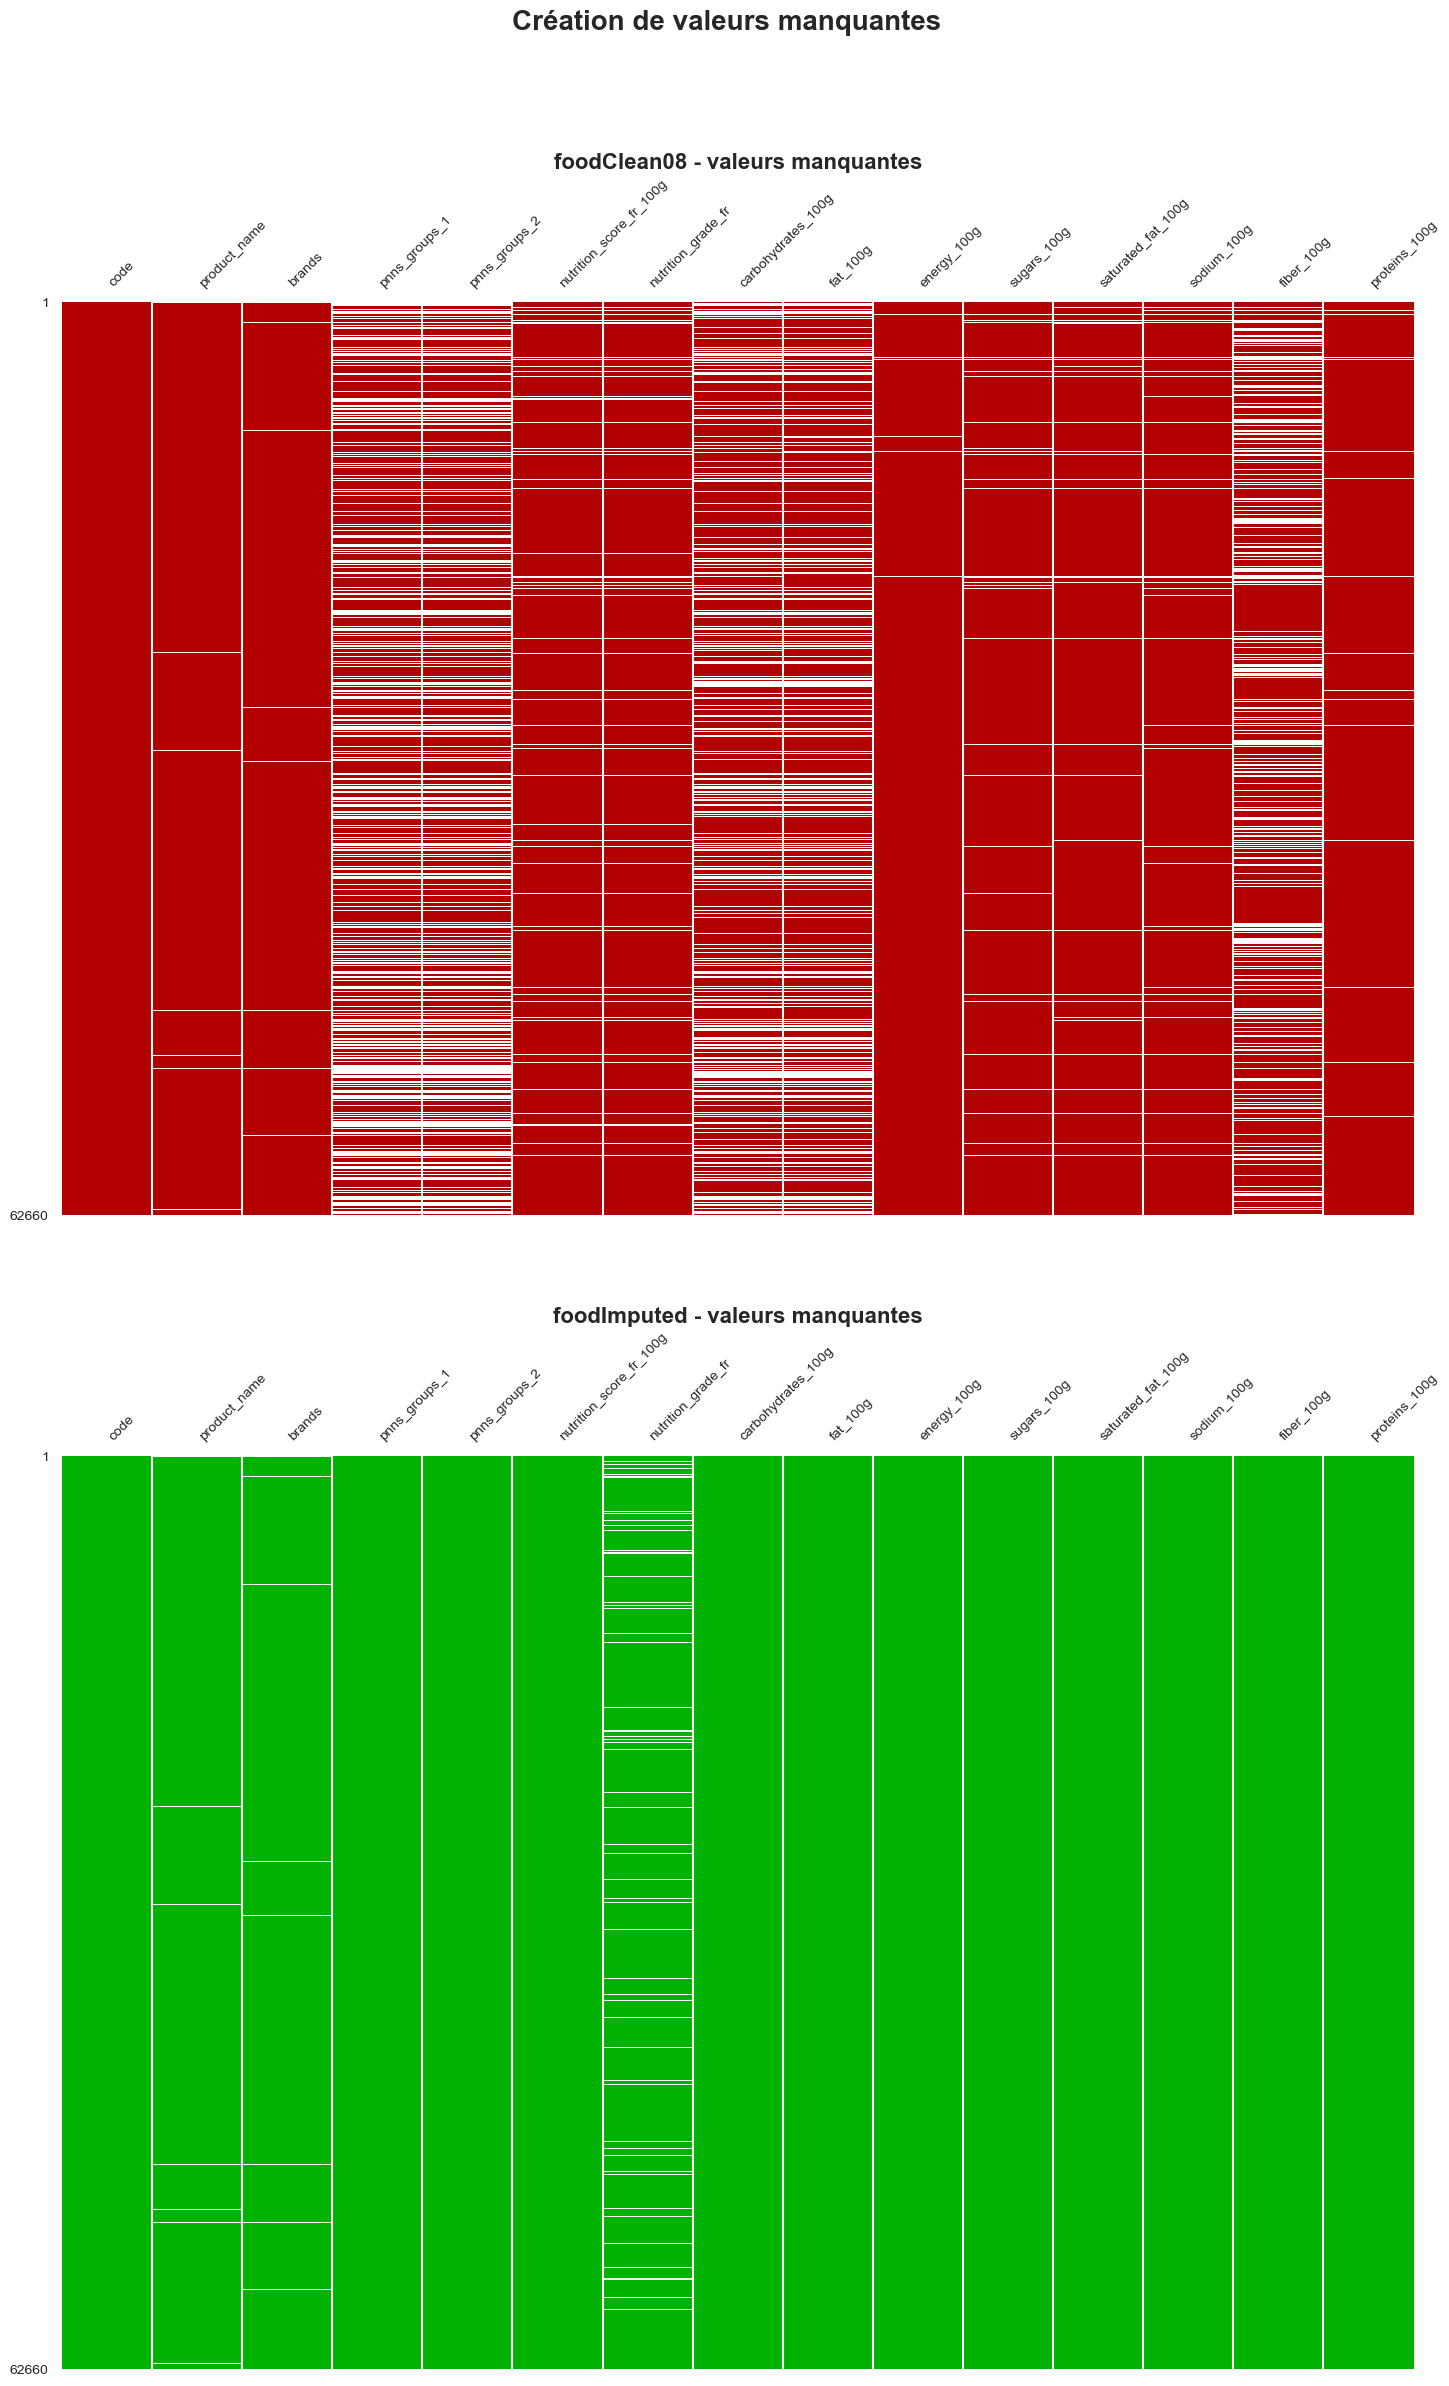

In [192]:
# visualisation of missing values

listOfDf=[foodClean08,foodImputed]
listOfDfNames=["foodClean08","foodImputed"]
listOfColors=[[0.7,0.0,0.0],[0.0,0.7,0.0]]

fig,axs=plt.subplots(len(listOfDf),1,figsize=(16,25))
fig.suptitle("Création de valeurs manquantes", fontweight="bold",fontsize=20) # set main title

# dataviz of missing data

for i in range(len(listOfDf)) :
    
    ms.matrix(listOfDf[i],color=listOfColors[i],sparkline=False,ax=axs[i]) 
    axs[i].set_title(listOfDfNames[i]+" - valeurs manquantes", fontweight="bold",fontsize=16) 
    axs[i].set_xticklabels(axs[i].get_xticklabels(),fontsize=10)
    axs[i].set_yticklabels(axs[i].get_yticklabels(),fontsize=10)
    
fig.tight_layout(pad=5.0)

plt.show()

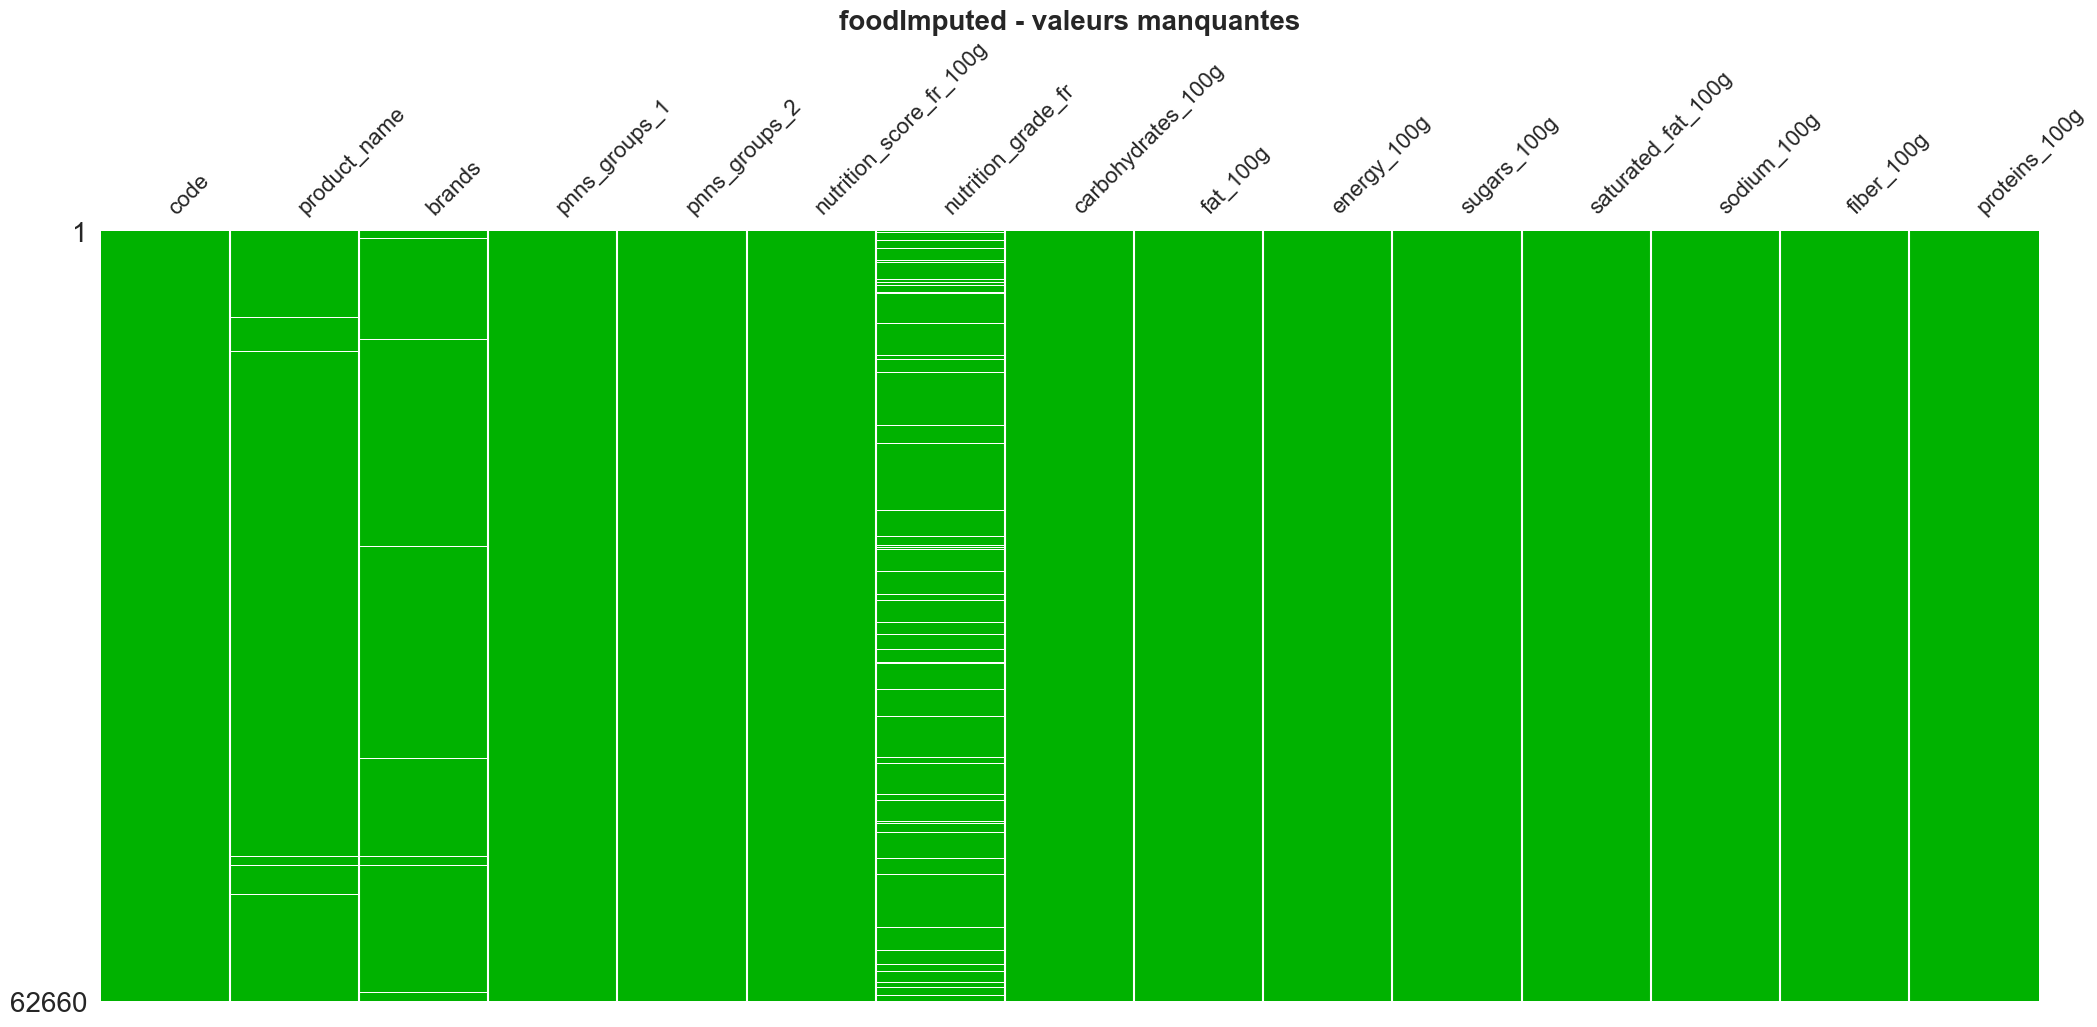

In [191]:




# visualisation of missing values
ms.matrix(foodImputed,color=[0.0,0.7,0.0],sparkline=False) # dataviz of missing data
plt.title("foodImputed - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

# Partie 3 - Exploration

# Tests -  score nutritionnel et nutrigrade

In [ ]:
testNutri=foodClean02[["nutrition_grade_fr","nutrition_score_fr_100g"]].copy()
testNutri=testNutri.loc[testNutri.notna().any(axis=1)]
testNutri=testNutri.sort_values("nutrition_grade_fr")

In [ ]:
sns.set(style="darkgrid")
myPalette= {"a": "#02663B",
           "b": "#8DC83E",
           "c" : "#F4E300",
           "d" : "#F7941D",
           "e" : "#C31D2A",
           }
sns.boxplot(data=testNutri,x="nutrition_grade_fr",y="nutrition_score_fr_100g",palette=myPalette);

# Tests -  énergie et nutrigrade

In [ ]:
testEnerNut=foodClean02[["nutrition_grade_fr","energy_100g"]].copy()

In [ ]:
testEnerNut=testEnerNut.loc[testEnerNut.notna().any(axis=1)]
testEnerNut=testEnerNut.loc[testEnerNut["energy_100g"]<3700]
testEnerNut=testEnerNut.sort_values("nutrition_grade_fr")

In [ ]:
sns.boxplot(data=testEnerNut,x="nutrition_grade_fr",y="energy_100g",palette=myPalette)

# Tests -  énergie et nutrigrade

In [ ]:
foodRaw.pnns_groups_2.value_counts()

In [ ]:
%pwd

In [ ]:
errorsForPnns2.idxmax(axis=0)